In [1]:
import optuna
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader,random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, transforms
from torch_lr_finder import LRFinder

import h5py
from datetime import datetime
import matplotlib.pyplot as plt
import copy
from Library.datasets import DatasetH5TwoRandom, DatasetH5ForTest, compute_std_mean
from Library.transforms import RandomFlip,RandomOffset,RandomRotateGrayscale
from Library.scheduler import OneCycleLR,LogLR
from Library.cresnet import initialize_cresnet
from Library.dml import RefBasedDeepMetric
from Library.models.FeatureExtractor import FeatureExtractor, Block, CustomNet
from Library.trainers import RefBasedDeepMetricTrainer
from tqdm.notebook import tqdm

In [2]:
from Library.util import (
    jupyter_wide_screen,
    strings_contain_words, 
    strings_contain_patterns, 
    add_unique_entry
)

jupyter_wide_screen()

In [3]:
def init_dataset(path,seq_idx_list,mean_val,std_val):

    ds_h5 = []
    refs_list = []

    img_transforms = [RandomRotateGrayscale(rot_range=[-0.1, 0.1], fill=150),
                      RandomFlip(lr_prob=0.5, ud_prob=0.5),
                      transforms.ToTensor(),
                      transforms.Normalize((mean_val,),(std_val,))]
    
    composed_img_transforms = transforms.Compose(img_transforms)
    
    # to obtain the Seq data
    for seq_idx in seq_idx_list:
        h5_fpath = path.format(seq_idx)
        h5_f = DatasetH5TwoRandom(h5_fpath,num_ref = 32,transform = composed_img_transforms)
        
        # obtain the references, the first 10 images in every Seq.
        refs = h5_f.getRef()
        refs_list.append(refs)
        
        ds_h5.append(h5_f)

    return refs_list, ds_h5

def init_dataloaders(datasets,ds_ratio):
    dataloaders = []
    
    for ds in datasets:
        splitted_ds_num_data = [round(len(ds) * ds_ratio[i]) for i in range(len(ds_ratio))]
        splitted_ds_num_data[0] += len(ds) - int(np.sum(splitted_ds_num_data))

        splitted_ds = []

        for tmp_ds, batch_size, shuffle in zip(random_split(ds, splitted_ds_num_data), batch_sizes, shuffle_flags):

            splitted_ds.append(
                DataLoader(
                    tmp_ds,
                    batch_size=batch_size,
                    shuffle=shuffle,
                    drop_last=True,
                )
            )

        dataloaders.append(splitted_ds)
    return dataloaders


## Load Model

In [4]:
model_path = 'optuna_models/RefFreeDeepMetric_Model_v6_old_3stride_t2'

In [5]:
with open(os.path.join(model_path, 'config.json')) as f:
    cresnet_config = json.load(f)
    
weight_fpath = os.path.join(model_path, 'model.weight')

device = torch.device("cuda:0")

In [6]:
cresnet_config

{'loss_non_linearity_name': 'sigmoid',
 'criterion_name': 'bce',
 'cresnet_config': {'InputShape': [1, 720, 24],
  'BlockName': 'LeakyBasicBlock',
  'NumBlocks': [3, 3, 3, 3, 3, 3, 3],
  'NumChannels': [24, 24, 48, 48, 96, 96, 192],
  'Strides': [[2, 2], [2, 2], [2, 1], [2, 2], [2, 2], [2, 1], [2, 1]],
  'NumNeurons': [32],
  'EnableGlobalAveragePooling': True,
  'PrintIntermediateShape': False,
  'InitializeResidual': True}}

In [ ]:
cresnet_config = {
        'InputShape' : [1, 720, 24],
        'BlockName' : 'LeakyBasicBlock',
        'NumBlocks' : [3, 3, 3, 3, 3, 3, 3],
        'NumChannels' : [24, 24, 48, 48, 96, 96, 192],
        'Strides' :[[2, 2], [2, 2], [2, 1], [2, 2], [2, 2], [2, 1], [2, 1]],
        'NumNeurons' :[32],
        'EnableGlobalAveragePooling' : True,
        'PrintIntermediateShape' : True,
        'InitializeResidual': True,
    }

In [ ]:
feature_extractor = initialize_cresnet(cresnet_config, device)
model = RefBasedDeepMetric(
    feature_extractor, 
    loss_non_linearity_name='sigmoid',
    criterion_name='bce',)

In [7]:
# not use pre-trained
model = RefBasedDeepMetric.load_pretrained_cresnet(model_path, device, show_config=True)

{'loss_non_linearity_name': 'sigmoid', 'criterion_name': 'bce', 'cresnet_config': {'InputShape': [1, 720, 24], 'BlockName': 'LeakyBasicBlock', 'NumBlocks': [3, 3, 3, 3, 3, 3, 3], 'NumChannels': [24, 24, 48, 48, 96, 96, 192], 'Strides': [[2, 2], [2, 2], [2, 1], [2, 2], [2, 2], [2, 1], [2, 1]], 'NumNeurons': [32], 'EnableGlobalAveragePooling': True, 'PrintIntermediateShape': False, 'InitializeResidual': True}}


In [8]:
model.to(device)

RefBasedDeepMetric(
  (feature_extractor): CResNet(
    (Block0): Sequential(
      (0): LeakyBasicBlock(
        (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=[2, 2], padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.01, inplace=True)
        (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential(
          (0): Conv2d(1, 24, kernel_size=(1, 1), stride=[2, 2], bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): LeakyBasicBlock(
        (conv1): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Test Model

In [9]:
def init_test_dataset(path,seq_idx_list,mean_val,std_val):

    ds_h5_test = []
    refs_list = []
    
    ### 可能还需要用 transforms.RandomHorizontalFlip()
    #img_transforms = [transforms.ToTensor(),transforms.Normalize((mean_val,),(std_val,))] # 先标准化处理
    img_transforms = [RandomRotateGrayscale(rot_range=[-0.1, 0.1], fill=150),
                      RandomFlip(lr_prob=0.5, ud_prob=0.5),
                      transforms.ToTensor(),
                      transforms.Normalize((mean_val,),(std_val,))]
    
    composed_img_transforms = transforms.Compose(img_transforms)
    
    # to obtain the Seq data
    for seq_idx in seq_idx_list:
        h5_fpath = path.format(seq_idx)
        h5_f_test =  DatasetH5ForTest(h5_fpath,num_ref=32,normalize_im=False, transform = composed_img_transforms)
        
        # obtain the references, the first 10 images in every Seq.
        refs = h5_f_test.getRef()
        refs_list.append(refs)

        ds_h5_test.append(h5_f_test)
    
    return refs_list, ds_h5_test

In [10]:
#data_path_type1 = "../MA/NewData/22008_1000202026_652510007"
#fnames_type1 = "CleanOutliers_Padding_roi_seq{}_720x24.h5"
data_path_type1 = "../MA/NewData/22008_1000202026_652510007"
fnames_type1 = "Padding_regenerated_roi_ms1_seq{}_720x24.h5"
combined_path_type1 = os.path.join(data_path_type1, fnames_type1)
seq_idx_list_type1 = [0,1,2,3,4,5,6]

In [11]:
inputs_shape = [1,720,24]
batch_sizes = [32, 32, 32]
shuffle_flags = [True, False, False]
ds_ratio = [0.6, 0.2, 0.2]

In [12]:
mean_val = 0
std_val = 255
refs_list, ds_h5 = init_dataset(combined_path_type1, seq_idx_list_type1, mean_val, std_val)

In [13]:
len(refs_list[0])

32

In [14]:
dataloaders = init_dataloaders(ds_h5, ds_ratio)

train_dls = [dls[0] for dls in dataloaders]
valid_dls = [dls[1] for dls in dataloaders]
test_dls = [dls[2] for dls in dataloaders]

## LR Test

In [15]:
from torch.optim.lr_scheduler import _LRScheduler
from torch_lr_finder import LRFinder ,TrainDataLoaderIter, ValDataLoaderIter

In [16]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        img1, img2, labels = batch_data
        return img1, img2, labels
    
    def __next__(self):
        try:
            batch = next(self._iterator)
            img1, img2, labels = self.inputs_labels_from_batch(batch)
        except StopIteration:
            if not self.auto_reset:
                raise
            self._iterator = iter(self.data_loader)
            batch = next(self._iterator)
            img1, img2, labels = self.inputs_labels_from_batch(batch)

        return img1, img2, labels

In [17]:
class CustomValIter(ValDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        img1, img2, labels = batch_data
        return img1, img2, labels

In [18]:
class LinearLR(_LRScheduler):
    """Linearly increases the learning rate between two boundaries over a number of
    iterations.

    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float): the final learning rate.
        num_iter (int): the number of iterations over which the test occurs.
        last_epoch (int, optional): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr

        if num_iter <= 1:
            raise ValueError("`num_iter` must be larger than 1")
        self.num_iter = num_iter

        super(LinearLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        r = self.last_epoch / (self.num_iter - 1)

        return [base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs]

In [19]:
class ExponentialLR(_LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of
    iterations.

    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float): the final learning rate.
        num_iter (int): the number of iterations over which the test occurs.
        last_epoch (int, optional): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr

        if num_iter <= 1:
            raise ValueError("`num_iter` must be larger than 1")
        self.num_iter = num_iter

        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        # In earlier Pytorch versions last_epoch starts at -1, while in recent versions
        # it starts at 0. We need to adjust the math a bit to handle this. See
        # discussion at: https://github.com/davidtvs/pytorch-lr-finder/pull/42
        
        r = self.last_epoch / (self.num_iter - 1)

        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

In [20]:
try:
    from apex import amp

    IS_AMP_AVAILABLE = True
except ImportError:
    IS_AMP_AVAILABLE = False
    
class CustomLRFinder(LRFinder):
    
    def custom_range_test(
        self,
        train_loader,
        curr_refs,
        val_loader=None,
        start_lr=None,
        end_lr=10,
        num_iter=100,
        step_mode="exp",
        smooth_f=0.05,
        diverge_th=5,
        accumulation_steps=1,
        non_blocking_transfer=True,
    ):
       
        # Reset test results
        self.history = {"lr": [], "loss": []}
        self.best_loss = None

        # Move the model to the proper device
        self.model.to(self.device)

        # Check if the optimizer is already attached to a scheduler
        self._check_for_scheduler()

        # Set the starting learning rate
        if start_lr:
            self._set_learning_rate(start_lr)

        # Initialize the proper learning rate policy
        if step_mode.lower() == "exp":
            lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":
            lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")

        # Create an iterator to get data batch by batch
        if isinstance(train_loader, DataLoader):
            train_iter = TrainDataLoaderIter(train_loader)
        elif isinstance(train_loader, TrainDataLoaderIter):
            train_iter = train_loader
        else:
            raise ValueError(
                "`train_loader` has unsupported type: {}."
                "Expected types are `torch.utils.data.DataLoader`"
                "or child of `TrainDataLoaderIter`.".format(type(train_loader))
            )

        if val_loader:
            if isinstance(val_loader, DataLoader):
                val_iter = CustomValIter(val_loader)
            elif isinstance(val_loader, ValDataLoaderIter):
                val_iter = val_loader
            else:
                raise ValueError(
                    "`val_loader` has unsupported type: {}."
                    "Expected types are `torch.utils.data.DataLoader`"
                    "or child of `ValDataLoaderIter`.".format(type(val_loader))
                )

        for iteration in tqdm(range(num_iter)):
            # Train on batch and retrieve loss
            loss = self._train_batch(
                train_iter,
                curr_refs,
                accumulation_steps,
                non_blocking_transfer= non_blocking_transfer,
            )
            if val_loader:
                loss = self._validate(
                    val_iter, curr_refs, non_blocking_transfer=non_blocking_transfer
                )

            # Update the learning rate
            self.history["lr"].append(lr_schedule.get_lr()[0])
            lr_schedule.step()

            # Track the best loss and smooth it if smooth_f is specified
            if iteration == 0:
                self.best_loss = loss
            else:
                if smooth_f > 0:
                    loss = smooth_f * loss + (1 - smooth_f) * self.history["loss"][-1]
                if loss < self.best_loss:
                    self.best_loss = loss

            # Check if the loss has diverged; if it has, stop the test
            self.history["loss"].append(loss)
            if loss > diverge_th * self.best_loss:
                print("Stopping early, the loss has diverged")
                break

        print("Learning rate search finished. See the graph with {finder_name}.plot()")

    def _train_batch(self, train_iter, curr_refs, accumulation_steps, non_blocking_transfer=True):
        self.model.train()
        total_loss = None  # for late initialization
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.optimizer.zero_grad()
        curr_refs = curr_refs.float().to(device)

        for i in range(accumulation_steps):
            img1, img2, labels = next(train_iter)
            labels = labels.view(-1)
            labels = labels.to(device)
            img1 = img1.float().to(device)
            img2 = img2.float().to(device)

            # Forward pass
            loss, preds = self.model.compute_loss(img1, img2, curr_refs, labels)

            # Loss should be averaged in each step
            loss /= accumulation_steps

            # Backward pass
            if IS_AMP_AVAILABLE and hasattr(self.optimizer, "_amp_stash"):
                # For minor performance optimization, see also:
                # https://nvidia.github.io/apex/advanced.html#gradient-accumulation-across-iterations
                delay_unscale = ((i + 1) % accumulation_steps) != 0

                with amp.scale_loss(
                    loss, self.optimizer, delay_unscale=delay_unscale
                ) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if total_loss is None:
                total_loss = loss
            else:
                total_loss += loss

        self.optimizer.step()

        return total_loss.item()
    
    def _validate(self, val_iter, curr_refs, non_blocking_transfer=True):
        # Set model to evaluation mode and disable gradient computation
        running_loss = 0
        self.model.eval()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        curr_refs = curr_refs.float().to(device)
        with torch.no_grad():
            for img1, img2, labels in val_iter:
                # Move data to the correct device
                labels = labels.view(-1)
                labels = labels.to(device)
                img1 = img1.float().to(device)
                img2 = img2.float().to(device)

                # Forward pass and loss computation
                loss, preds = self.model.compute_loss(img1, img2, curr_refs, labels)
                running_loss += loss.item() * len(labels)

        return running_loss / len(val_iter.dataset)
    

In [21]:
start_lr = 1e-8

min_lr_factor = 1
anneal_lr_factor= 1e-1

train_dl_idx = 0
valid_dl_idx = 1
test_dl_idx = 2
refs_dl_idx = 0

optimizer = torch.optim.Adam(model.parameters(),lr=start_lr, eps=1e-08, weight_decay=0)
#optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=0.5)
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss(reduction = 'none')
criterion = nn.BCELoss()


Learning rate search finished. See the graph with {finder_name}.plot()


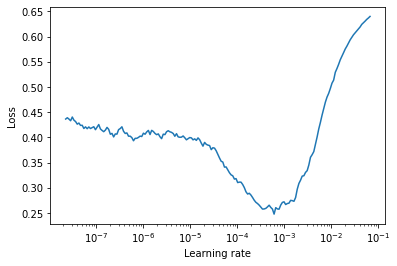

In [22]:
#lr_finder.reset()
lr_finder = CustomLRFinder(model, optimizer, criterion, device="cuda")

# seq dataloader / shuffel the dataloader
for refs, train_dl, val_dl in zip (refs_list, train_dls, valid_dls):
    custom_train_iter = CustomTrainIter(train_dl)
    custom_val_iter = CustomValIter(val_dl)
lr_finder.custom_range_test(custom_train_iter, curr_refs = refs, end_lr=0.1, num_iter=200)
lr_finder.plot(suggest_lr = False)
lr_finder.reset()

In [23]:
num_epochs = 50

lr = 3.16e-4

min_lr_factor = 0.1
phases_ratio = [0.3, 0.2, 0.3, 0.2]

train_dl_idx = 0
valid_dl_idx = 1
test_dl_idx = 2

run_train = True

net_path = "../MA/save_net/"
criterion = nn.BCELoss()
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S)")
print('Current Timestamp : ', timestampStr)

Current Timestamp :  29-May-2021 (22:09:38)


Total Train Iterations:  578
Total Train Iterations List:  [36, 81, 208, 290, 387, 474, 578]
Valid iterations per seq:  [12, 15, 42, 27, 33, 29, 34]


Train



Sequence:1, Seq Training Mean Loss: 0.2529205758538511, Seq Training Acc: 0.8958333333333334
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2736086347036891, Seq Training Acc: 0.8743055555555556
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.28184140461871005, Seq Training Acc: 0.874507874015748
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.2224249169230461, Seq Training Acc: 0.9005335365853658
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.254516366753996, Seq Training Acc: 0.8888530927835051
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.27323440325328674, Seq Training Acc: 0.8775143678160919
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.1940830102763497, Seq Training Acc: 0.9164663461538461
******************************************************************
Epoch:1, Epoch Training Loss Mean: 0.24929817020893097, Epoch Training Acc: 0.8899221453287197
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6977452983458837, Seq Valid Acc: 0.6666666666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.31057134370009104, Seq Valid Acc: 0.86875



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.35704394926627475, Seq Valid Acc: 0.8340773809523809



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.33867508945641694, Seq Valid Acc: 0.8414351851851852



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.3993347729697372, Seq Valid Acc: 0.8191287878787878



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.4839109079591159, Seq Valid Acc: 0.7747844827586207



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.33478487984222527, Seq Valid Acc: 0.8409926470588235
Epoch:1, Epoch Valid Mean Loss: 0.3946131765842438, Epoch Valid Acc: 0.8170572916666666
******************************************************************


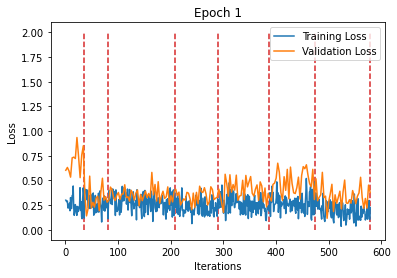

Train



Sequence:1, Seq Training Mean Loss: 0.19237390408913294, Seq Training Acc: 0.9175347222222222
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.22883741789393955, Seq Training Acc: 0.8881944444444444
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2513667552724598, Seq Training Acc: 0.8845964566929134
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.22450187493388246, Seq Training Acc: 0.9005335365853658
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.23736053782025562, Seq Training Acc: 0.8943298969072165
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.2668045750637164, Seq Training Acc: 0.8775143678160919
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.16596055564542228, Seq Training Acc: 0.9305889423076923
******************************************************************
Epoch:2, Epoch Training Loss Mean: 0.22673311829566956, Epoch Training Acc: 0.8980320069204152
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6227460702260336, Seq Valid Acc: 0.703125



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.2323645144701004, Seq Valid Acc: 0.8958333333333334



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.3803576458068121, Seq Valid Acc: 0.8266369047619048



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.3744793512203075, Seq Valid Acc: 0.8402777777777778



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.38362170078537683, Seq Valid Acc: 0.821969696969697



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.498125284910202, Seq Valid Acc: 0.7629310344827587



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.32251836622462554, Seq Valid Acc: 0.8575367647058824
Epoch:2, Epoch Valid Mean Loss: 0.39122477173805237, Epoch Valid Acc: 0.8212890625
******************************************************************


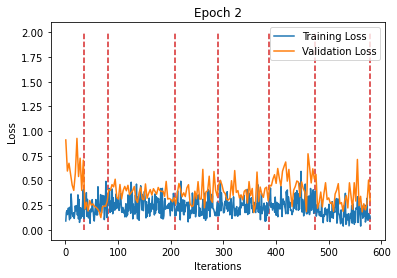

Train



Sequence:1, Seq Training Mean Loss: 0.1916656382381916, Seq Training Acc: 0.9192708333333334
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.1805184594872925, Seq Training Acc: 0.9138888888888889
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.24720611675517765, Seq Training Acc: 0.8885334645669292
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.2007445870648797, Seq Training Acc: 0.9146341463414634
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.22676685606081462, Seq Training Acc: 0.8998067010309279
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.2600023993130388, Seq Training Acc: 0.8839798850574713
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.1845047754020645, Seq Training Acc: 0.9233774038461539
******************************************************************
Epoch:3, Epoch Training Loss Mean: 0.21917752921581268, Epoch Training Acc: 0.9036007785467128
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.7539002150297165, Seq Valid Acc: 0.671875



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.2808182746171951, Seq Valid Acc: 0.8833333333333333



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.35865938166777295, Seq Valid Acc: 0.8415178571428571



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.3842228595857267, Seq Valid Acc: 0.8229166666666666



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.33601112708900915, Seq Valid Acc: 0.8409090909090909



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.4320050714344814, Seq Valid Acc: 0.8006465517241379



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.295203281676068, Seq Valid Acc: 0.8602941176470589
Epoch:3, Epoch Valid Mean Loss: 0.3768240511417389, Epoch Valid Acc: 0.82861328125
******************************************************************


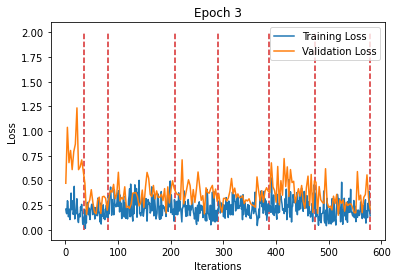

Train



Sequence:1, Seq Training Mean Loss: 0.19270838031338322, Seq Training Acc: 0.9114583333333334
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.20504385381937026, Seq Training Acc: 0.9034722222222222
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.24837134385437476, Seq Training Acc: 0.8875492125984252
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.21887984081375889, Seq Training Acc: 0.897484756097561
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.24840892981929877, Seq Training Acc: 0.8946520618556701
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.24020849527983829, Seq Training Acc: 0.8943965517241379
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.1806582870105138, Seq Training Acc: 0.9227764423076923
******************************************************************
Epoch:4, Epoch Training Loss Mean: 0.22394126653671265, Epoch Training Acc: 0.9002487024221453
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 1.06076783935229, Seq Valid Acc: 0.5078125



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.279205651084582, Seq Valid Acc: 0.89375



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.4324429907969066, Seq Valid Acc: 0.7924107142857143



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.4089434466980122, Seq Valid Acc: 0.8101851851851852



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.38047523028922803, Seq Valid Acc: 0.8267045454545454



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.5437730735745924, Seq Valid Acc: 0.7661637931034483



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.4104081256424679, Seq Valid Acc: 0.8069852941176471
Epoch:4, Epoch Valid Mean Loss: 0.4604184925556183, Epoch Valid Acc: 0.78955078125
******************************************************************


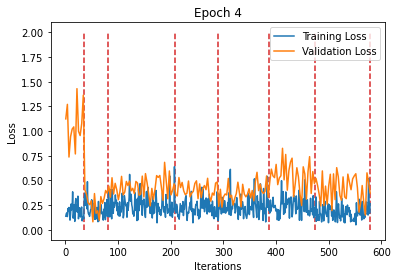

Train



Sequence:1, Seq Training Mean Loss: 0.2109798602759838, Seq Training Acc: 0.9045138888888888
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.21619614313046137, Seq Training Acc: 0.8944444444444445
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.24566953265526165, Seq Training Acc: 0.8927165354330708
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.23753281464663947, Seq Training Acc: 0.8940548780487805
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2567810744200785, Seq Training Acc: 0.8865979381443299
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.2724930689423934, Seq Training Acc: 0.8818247126436781
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.19015660104700005, Seq Training Acc: 0.9176682692307693
******************************************************************
Epoch:5, Epoch Training Loss Mean: 0.23597364127635956, Epoch Training Acc: 0.8955990484429066
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.4307609498500824, Seq Valid Acc: 0.8255208333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.2845754126707713, Seq Valid Acc: 0.875



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.39324679261162165, Seq Valid Acc: 0.8117559523809523



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.5248372345059006, Seq Valid Acc: 0.7557870370370371



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4245496193567912, Seq Valid Acc: 0.7878787878787878



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.5289780363954347, Seq Valid Acc: 0.7338362068965517



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.23950516870793173, Seq Valid Acc: 0.8933823529411765
Epoch:5, Epoch Valid Mean Loss: 0.4042625427246094, Epoch Valid Acc: 0.8082682291666666
******************************************************************


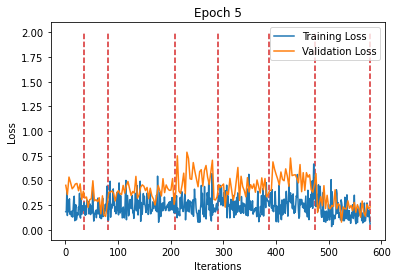

Train



Sequence:1, Seq Training Mean Loss: 0.21616367995738983, Seq Training Acc: 0.8967013888888888
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.24787374171945784, Seq Training Acc: 0.8826388888888889
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2521726395201495, Seq Training Acc: 0.8863188976377953
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.24877724523951367, Seq Training Acc: 0.8871951219512195
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.24719394474607154, Seq Training Acc: 0.8878865979381443
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.2782305694859603, Seq Training Acc: 0.8742816091954023
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.1912720720641888, Seq Training Acc: 0.9191706730769231
******************************************************************
Epoch:6, Epoch Training Loss Mean: 0.24124230444431305, Epoch Training Acc: 0.8911656574394463
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 1.1995832373698552, Seq Valid Acc: 0.4661458333333333



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.26919782161712646, Seq Valid Acc: 0.88125



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.45146292802833377, Seq Valid Acc: 0.7819940476190477



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.5209694460586265, Seq Valid Acc: 0.7453703703703703



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4034071320837194, Seq Valid Acc: 0.8087121212121212



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.46211418355333395, Seq Valid Acc: 0.7855603448275862



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.3408587469774134, Seq Valid Acc: 0.84375
Epoch:6, Epoch Valid Mean Loss: 0.4675184190273285, Epoch Valid Acc: 0.7809244791666666
******************************************************************


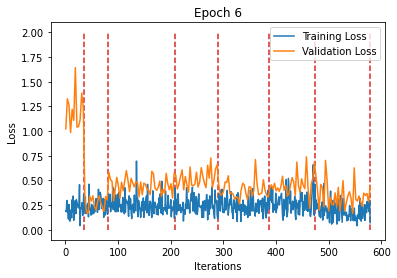

Train



Sequence:1, Seq Training Mean Loss: 0.23402679504619706, Seq Training Acc: 0.9036458333333334
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.22274290141132141, Seq Training Acc: 0.8972222222222223
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.27453485184063126, Seq Training Acc: 0.87623031496063
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.2414941425185378, Seq Training Acc: 0.8982469512195121
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.27141610678938244, Seq Training Acc: 0.8814432989690721
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.29484657412287835, Seq Training Acc: 0.8699712643678161
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.22231287097271818, Seq Training Acc: 0.9041466346153846
******************************************************************
Epoch:7, Epoch Training Loss Mean: 0.2564297616481781, Epoch Training Acc: 0.887651384083045
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.8245010077953339, Seq Valid Acc: 0.5338541666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.23551074067751568, Seq Valid Acc: 0.8916666666666667



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.5083132797763461, Seq Valid Acc: 0.7485119047619048



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.49807596758559897, Seq Valid Acc: 0.7708333333333334



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4316138137470592, Seq Valid Acc: 0.8096590909090909



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.6406274479011009, Seq Valid Acc: 0.7532327586206896



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.3511785930570434, Seq Valid Acc: 0.8483455882352942
Epoch:7, Epoch Valid Mean Loss: 0.484298974275589, Epoch Valid Acc: 0.7783203125
******************************************************************


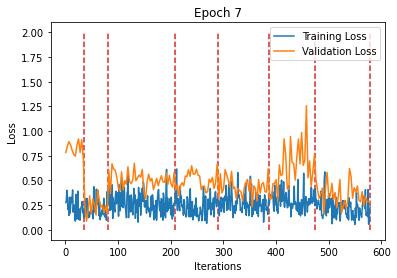

Train



Sequence:1, Seq Training Mean Loss: 0.2464985108623902, Seq Training Acc: 0.9053819444444444
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.25876137051317427, Seq Training Acc: 0.8861111111111111
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.27884580910675166, Seq Training Acc: 0.8809055118110236
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.24430311125953022, Seq Training Acc: 0.8913871951219512
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2683144458329555, Seq Training Acc: 0.8807989690721649
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.29161198539980526, Seq Training Acc: 0.8699712643678161
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.20068238356795448, Seq Training Acc: 0.9137620192307693
******************************************************************
Epoch:8, Epoch Training Loss Mean: 0.25645712018013, Epoch Training Acc: 0.8885705017301038
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5405092189709345, Seq Valid Acc: 0.7552083333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.271031587322553, Seq Valid Acc: 0.8791666666666667



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.5312130273807616, Seq Valid Acc: 0.7276785714285714



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.5516263765317423, Seq Valid Acc: 0.7465277777777778



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4256328994577581, Seq Valid Acc: 0.7973484848484849



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.5872138317289024, Seq Valid Acc: 0.7478448275862069



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.39481327682733536, Seq Valid Acc: 0.8207720588235294
Epoch:8, Epoch Valid Mean Loss: 0.48049578070640564, Epoch Valid Acc: 0.775390625
******************************************************************


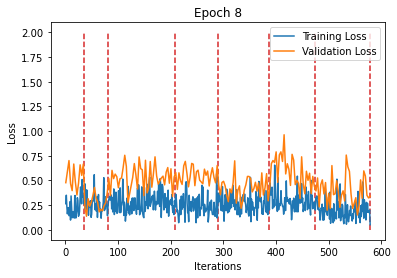

Train



Sequence:1, Seq Training Mean Loss: 0.24093530947963396, Seq Training Acc: 0.8932291666666666
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2590806590186225, Seq Training Acc: 0.8861111111111111
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2730543506075078, Seq Training Acc: 0.8804133858267716
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.2571909333147654, Seq Training Acc: 0.8883384146341463
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.27667463563152195, Seq Training Acc: 0.8772551546391752
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.2825056204850646, Seq Training Acc: 0.8771551724137931
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.20298192972460619, Seq Training Acc: 0.9137620192307693
******************************************************************
Epoch:9, Epoch Training Loss Mean: 0.25713738799095154, Epoch Training Acc: 0.8877595155709342
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.570923979083697, Seq Valid Acc: 0.7526041666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.3236183116833369, Seq Valid Acc: 0.85



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.45058731805710567, Seq Valid Acc: 0.7745535714285714



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.43533682602423207, Seq Valid Acc: 0.8032407407407407



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4232690307227048, Seq Valid Acc: 0.8039772727272727



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.5498391759806666, Seq Valid Acc: 0.7521551724137931



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.26373081720050645, Seq Valid Acc: 0.8685661764705882
Epoch:9, Epoch Valid Mean Loss: 0.4232510030269623, Epoch Valid Acc: 0.8014322916666666
******************************************************************


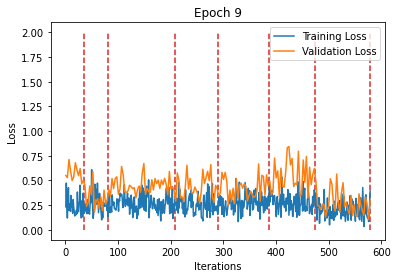

Train



Sequence:1, Seq Training Mean Loss: 0.22207477192083994, Seq Training Acc: 0.8993055555555556
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2399598878290918, Seq Training Acc: 0.8944444444444445
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.27914544822662835, Seq Training Acc: 0.8718011811023622
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.2642070352122551, Seq Training Acc: 0.8814786585365854
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2425040227082587, Seq Training Acc: 0.8923969072164949
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.2811410167607768, Seq Training Acc: 0.8778735632183908
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.21584082366182253, Seq Training Acc: 0.9047475961538461
******************************************************************
Epoch:10, Epoch Training Loss Mean: 0.2531815767288208, Epoch Training Acc: 0.8869485294117647
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5966937070091566, Seq Valid Acc: 0.7083333333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.322609277566274, Seq Valid Acc: 0.8666666666666667



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.495037181746392, Seq Valid Acc: 0.7388392857142857



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.49825336315013746, Seq Valid Acc: 0.7696759259259259



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4184946503603097, Seq Valid Acc: 0.803030303030303



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.4860717150671729, Seq Valid Acc: 0.7704741379310345



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.27276065551182804, Seq Valid Acc: 0.8795955882352942
Epoch:10, Epoch Valid Mean Loss: 0.43450069427490234, Epoch Valid Acc: 0.7919921875
******************************************************************


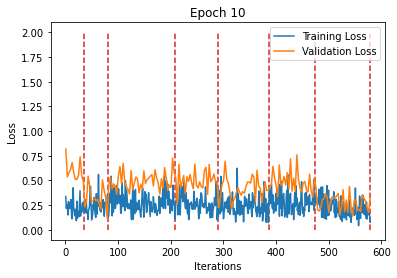

Train



Sequence:1, Seq Training Mean Loss: 0.22545307129621506, Seq Training Acc: 0.9001736111111112
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.24127989320291413, Seq Training Acc: 0.8909722222222223
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.288395451513801, Seq Training Acc: 0.8695866141732284
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.2623625295009555, Seq Training Acc: 0.8879573170731707
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2825813723593643, Seq Training Acc: 0.8759664948453608
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.2947035517500735, Seq Training Acc: 0.8724856321839081
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.20861341524869204, Seq Training Acc: 0.9089543269230769
******************************************************************
Epoch:11, Epoch Training Loss Mean: 0.26273226737976074, Epoch Training Acc: 0.8843533737024222
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.579964372018973, Seq Valid Acc: 0.7473958333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.31556241114934286, Seq Valid Acc: 0.8625



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.3862050800096421, Seq Valid Acc: 0.8296130952380952



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.397331926005858, Seq Valid Acc: 0.8460648148148148



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4209766107978243, Seq Valid Acc: 0.8153409090909091



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.453036360699555, Seq Valid Acc: 0.7887931034482759



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.298333284609458, Seq Valid Acc: 0.8639705882352942
Epoch:11, Epoch Valid Mean Loss: 0.3948708474636078, Epoch Valid Acc: 0.8268229166666666
******************************************************************


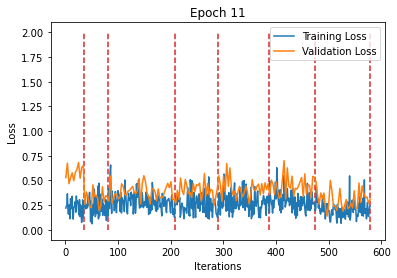

Train



Sequence:1, Seq Training Mean Loss: 0.2166389748454094, Seq Training Acc: 0.9036458333333334
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.24083587610059315, Seq Training Acc: 0.8951388888888889
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.27519968046447424, Seq Training Acc: 0.875
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.2483400309958109, Seq Training Acc: 0.8910060975609756
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.26227587522919643, Seq Training Acc: 0.8817654639175257
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.3084155122439067, Seq Training Acc: 0.8595545977011494
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.1960232755384193, Seq Training Acc: 0.9236778846153846
******************************************************************
Epoch:12, Epoch Training Loss Mean: 0.25365087389945984, Epoch Training Acc: 0.8881920415224913
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.7664001534382502, Seq Valid Acc: 0.5963541666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.266436822215716, Seq Valid Acc: 0.8875



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.5420787639561153, Seq Valid Acc: 0.7336309523809523



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.48031370948862145, Seq Valid Acc: 0.7743055555555556



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4251518457224875, Seq Valid Acc: 0.8039772727272727



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.4852993837718306, Seq Valid Acc: 0.7618534482758621



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.34207194517640505, Seq Valid Acc: 0.8520220588235294
Epoch:12, Epoch Valid Mean Loss: 0.4617879092693329, Epoch Valid Acc: 0.7801106770833334
******************************************************************


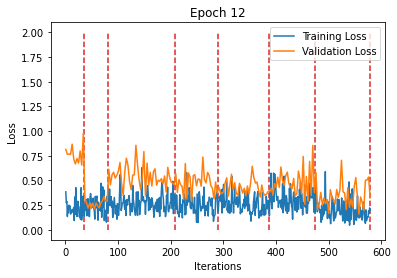

Train



Sequence:1, Seq Training Mean Loss: 0.24662713489184776, Seq Training Acc: 0.8862847222222222
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2291975584295061, Seq Training Acc: 0.8965277777777778
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2846332912252644, Seq Training Acc: 0.8708169291338582
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.28352981996608945, Seq Training Acc: 0.8746189024390244
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2806158823143576, Seq Training Acc: 0.8820876288659794
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.28509826838285074, Seq Training Acc: 0.867816091954023
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.19435005380700415, Seq Training Acc: 0.9116586538461539
******************************************************************
Epoch:13, Epoch Training Loss Mean: 0.2609446942806244, Epoch Training Acc: 0.8831098615916955
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6307324121395746, Seq Valid Acc: 0.6953125



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.3407179057598114, Seq Valid Acc: 0.8416666666666667



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.45972718866098494, Seq Valid Acc: 0.7775297619047619



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.4806836755187423, Seq Valid Acc: 0.7986111111111112



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.44789886474609375, Seq Valid Acc: 0.7888257575757576



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.46506589959407674, Seq Valid Acc: 0.7758620689655172



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.2993978244416854, Seq Valid Acc: 0.8667279411764706
Epoch:13, Epoch Valid Mean Loss: 0.4344461262226105, Epoch Valid Acc: 0.7978515625
******************************************************************


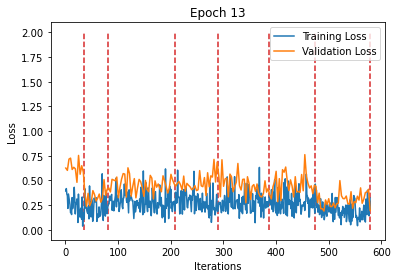

Train



Sequence:1, Seq Training Mean Loss: 0.2406054168111748, Seq Training Acc: 0.8914930555555556
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.21026743948459625, Seq Training Acc: 0.9090277777777778
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2846069398710108, Seq Training Acc: 0.875
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.27127349485711355, Seq Training Acc: 0.8757621951219512
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.267964963138718, Seq Training Acc: 0.876610824742268
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.28168597646143245, Seq Training Acc: 0.8724856321839081
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.21025874386899746, Seq Training Acc: 0.9047475961538461
******************************************************************
Epoch:14, Epoch Training Loss Mean: 0.2575770318508148, Epoch Training Acc: 0.8840289792387543
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5452698866526285, Seq Valid Acc: 0.7682291666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.2839766651391983, Seq Valid Acc: 0.89375



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.49369309274923234, Seq Valid Acc: 0.7514880952380952



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.5035800437132517, Seq Valid Acc: 0.7546296296296297



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.43358785275256995, Seq Valid Acc: 0.8039772727272727



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.4955512963492295, Seq Valid Acc: 0.7553879310344828



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.2597813724594958, Seq Valid Acc: 0.8814338235294118
Epoch:14, Epoch Valid Mean Loss: 0.4304511249065399, Epoch Valid Acc: 0.7967122395833334
******************************************************************


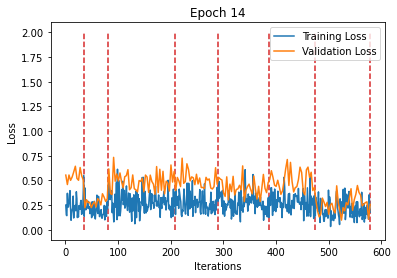

Train



Sequence:1, Seq Training Mean Loss: 0.23534356471565035, Seq Training Acc: 0.8958333333333334
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.22997432086202835, Seq Training Acc: 0.8958333333333334
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.27072948821651655, Seq Training Acc: 0.8767224409448819
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.23487431537814257, Seq Training Acc: 0.8967225609756098
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.24571520650816947, Seq Training Acc: 0.8959407216494846
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.30808059100447027, Seq Training Acc: 0.860632183908046
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.19185178232594177, Seq Training Acc: 0.9134615384615384
******************************************************************
Epoch:15, Epoch Training Loss Mean: 0.24749745428562164, Epoch Training Acc: 0.8896518166089965
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 1.061580424507459, Seq Valid Acc: 0.5130208333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.2923342674970627, Seq Valid Acc: 0.8791666666666667



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.425794080609367, Seq Valid Acc: 0.7834821428571429



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.4862489843810046, Seq Valid Acc: 0.7951388888888888



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.3992854284517693, Seq Valid Acc: 0.8304924242424242



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.7458959108796613, Seq Valid Acc: 0.6928879310344828



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.31055034477921095, Seq Valid Acc: 0.8704044117647058
Epoch:15, Epoch Valid Mean Loss: 0.48699045181274414, Epoch Valid Acc: 0.7854817708333334
******************************************************************


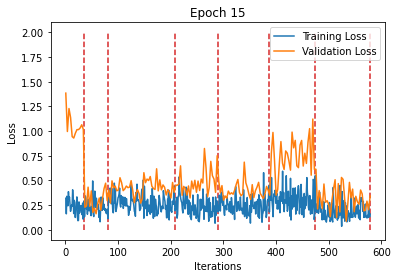

Train



Sequence:1, Seq Training Mean Loss: 0.22331803167859712, Seq Training Acc: 0.9071180555555556
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.22312793831030528, Seq Training Acc: 0.9
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.26033584943671867, Seq Training Acc: 0.8813976377952756
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.24725397630799106, Seq Training Acc: 0.8852896341463414
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.25582894598393097, Seq Training Acc: 0.8907860824742269
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.29144658473716384, Seq Training Acc: 0.865301724137931
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.17578192674913085, Seq Training Acc: 0.9221754807692307
******************************************************************
Epoch:16, Epoch Training Loss Mean: 0.2419900894165039, Epoch Training Acc: 0.8914900519031141
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.9259665509064993, Seq Valid Acc: 0.4921875



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.31299666663010917, Seq Valid Acc: 0.8583333333333333



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.42195405740113484, Seq Valid Acc: 0.7976190476190477



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.5734208744985086, Seq Valid Acc: 0.7210648148148148



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.40964709267471777, Seq Valid Acc: 0.7945075757575758



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.5104542795954079, Seq Valid Acc: 0.7532327586206896



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.28952938318252563, Seq Valid Acc: 0.8704044117647058
Epoch:16, Epoch Valid Mean Loss: 0.4540443420410156, Epoch Valid Acc: 0.7781575520833334
******************************************************************


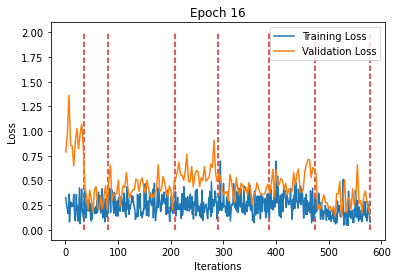

Train



Sequence:1, Seq Training Mean Loss: 0.22307544118828243, Seq Training Acc: 0.9027777777777778
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.24123602824078666, Seq Training Acc: 0.8881944444444444
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.26292096022663153, Seq Training Acc: 0.8818897637795275
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.25729372806665374, Seq Training Acc: 0.8860518292682927
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2640234809560874, Seq Training Acc: 0.882409793814433
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.28907536809471834, Seq Training Acc: 0.8746408045977011
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.1977645767172082, Seq Training Acc: 0.9143629807692307
******************************************************************
Epoch:17, Epoch Training Loss Mean: 0.2503507435321808, Epoch Training Acc: 0.8891111591695502
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.7590049505233765, Seq Valid Acc: 0.609375



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.2982838650544484, Seq Valid Acc: 0.85625



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.48884810436339604, Seq Valid Acc: 0.7633928571428571



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.5078891824792933, Seq Valid Acc: 0.7534722222222222



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4285125398274624, Seq Valid Acc: 0.8087121212121212



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.49880790915982476, Seq Valid Acc: 0.7650862068965517



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.3602646348230979, Seq Valid Acc: 0.8363970588235294
Epoch:17, Epoch Valid Mean Loss: 0.4618868827819824, Epoch Valid Acc: 0.7805989583333334
******************************************************************


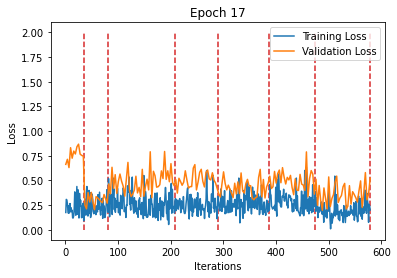

Train



Sequence:1, Seq Training Mean Loss: 0.23334752499229378, Seq Training Acc: 0.8940972222222222
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.24463364366028045, Seq Training Acc: 0.8909722222222223
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2700128605750602, Seq Training Acc: 0.8777066929133859
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.238472960344175, Seq Training Acc: 0.8982469512195121
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2561196700967464, Seq Training Acc: 0.8849871134020618
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.28692779296088494, Seq Training Acc: 0.8688936781609196
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.1890964680709518, Seq Training Acc: 0.921875
******************************************************************
Epoch:18, Epoch Training Loss Mean: 0.24693387746810913, Epoch Training Acc: 0.8905168685121108
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6224308808644613, Seq Valid Acc: 0.7135416666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.2979810476303101, Seq Valid Acc: 0.8729166666666667



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.41742861412820365, Seq Valid Acc: 0.8080357142857143



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.47080791106930486, Seq Valid Acc: 0.7835648148148148



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.3837302020101836, Seq Valid Acc: 0.8352272727272727



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.5755249909285841, Seq Valid Acc: 0.7273706896551724



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.33189962979625254, Seq Valid Acc: 0.8419117647058824
Epoch:18, Epoch Valid Mean Loss: 0.43135735392570496, Epoch Valid Acc: 0.80224609375
******************************************************************


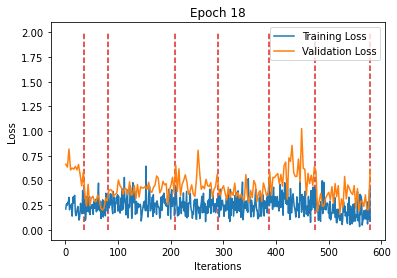

Train



Sequence:1, Seq Training Mean Loss: 0.21311506090892685, Seq Training Acc: 0.9114583333333334
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.21666372981336382, Seq Training Acc: 0.9020833333333333
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.26630425828648363, Seq Training Acc: 0.8845964566929134
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.25338125819476637, Seq Training Acc: 0.8921493902439024
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2490003796428749, Seq Training Acc: 0.8878865979381443
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.29643030276243715, Seq Training Acc: 0.8656609195402298
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.184633699639772, Seq Training Acc: 0.9200721153846154
******************************************************************
Epoch:19, Epoch Training Loss Mean: 0.24422889947891235, Epoch Training Acc: 0.8927876297577855
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 1.0394732753435771, Seq Valid Acc: 0.5546875



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.30237044890721637, Seq Valid Acc: 0.8708333333333333



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.44667753186963854, Seq Valid Acc: 0.796875



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.6143322454558479, Seq Valid Acc: 0.7083333333333334



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.42943496053869074, Seq Valid Acc: 0.8011363636363636



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.44887627507078237, Seq Valid Acc: 0.7823275862068966



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.35842584511812997, Seq Valid Acc: 0.8529411764705882
Epoch:19, Epoch Valid Mean Loss: 0.4777703285217285, Epoch Valid Acc: 0.7835286458333334
******************************************************************


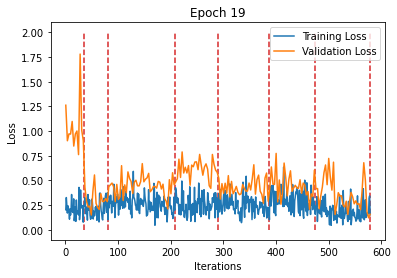

Train



Sequence:1, Seq Training Mean Loss: 0.23982575142549145, Seq Training Acc: 0.8967013888888888
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.24531473053826225, Seq Training Acc: 0.8888888888888888
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.23650327406999633, Seq Training Acc: 0.8959153543307087
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.2255324257946596, Seq Training Acc: 0.8940548780487805
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2634183849716924, Seq Training Acc: 0.8872422680412371
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.2680738075882539, Seq Training Acc: 0.8814655172413793
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.18247127586689132, Seq Training Acc: 0.9182692307692307
******************************************************************
Epoch:20, Epoch Training Loss Mean: 0.23538663983345032, Epoch Training Acc: 0.895544982698962
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.38459231207768124, Seq Valid Acc: 0.8515625



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.33114928801854454, Seq Valid Acc: 0.8625



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.45992272950354074, Seq Valid Acc: 0.7693452380952381



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.4475929814356345, Seq Valid Acc: 0.7997685185185185



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.3961792249571193, Seq Valid Acc: 0.8210227272727273



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.43742312028490266, Seq Valid Acc: 0.8081896551724138



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.23576297983527184, Seq Valid Acc: 0.9025735294117647
Epoch:20, Epoch Valid Mean Loss: 0.38937103748321533, Epoch Valid Acc: 0.8243815104166666
******************************************************************


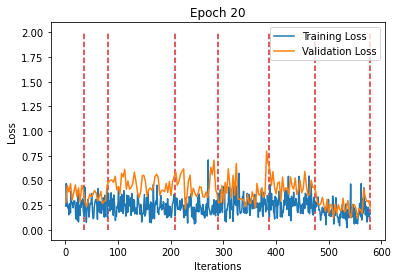

Train



Sequence:1, Seq Training Mean Loss: 0.20761041125903526, Seq Training Acc: 0.9088541666666666
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.21651982267697653, Seq Training Acc: 0.9111111111111111
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.24864496762944957, Seq Training Acc: 0.8838582677165354
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.24627616792553808, Seq Training Acc: 0.8868140243902439
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2573151458822882, Seq Training Acc: 0.8830541237113402
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.26889785267840854, Seq Training Acc: 0.8829022988505747
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.18678574754784888, Seq Training Acc: 0.9263822115384616
******************************************************************
Epoch:21, Epoch Training Loss Mean: 0.23662512004375458, Epoch Training Acc: 0.8953287197231834
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.8512720962365469, Seq Valid Acc: 0.5651041666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.2763523876667023, Seq Valid Acc: 0.86875



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.4943433105945587, Seq Valid Acc: 0.7574404761904762



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.4274087780051761, Seq Valid Acc: 0.7870370370370371



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.3905429140184865, Seq Valid Acc: 0.8210227272727273



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.4543015011425676, Seq Valid Acc: 0.7726293103448276



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.3186938355074209, Seq Valid Acc: 0.8483455882352942
Epoch:21, Epoch Valid Mean Loss: 0.4352148771286011, Epoch Valid Acc: 0.78759765625
******************************************************************


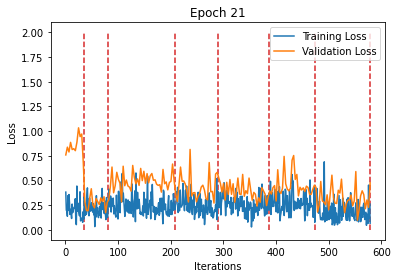

Train



Sequence:1, Seq Training Mean Loss: 0.21295390692022112, Seq Training Acc: 0.8958333333333334
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.22972834722863303, Seq Training Acc: 0.9027777777777778
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.26917039033934825, Seq Training Acc: 0.8781988188976378
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.26118847500623726, Seq Training Acc: 0.8879573170731707
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.25100785562979805, Seq Training Acc: 0.8914304123711341
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.25364633178573914, Seq Training Acc: 0.8864942528735632
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.19006889227491158, Seq Training Acc: 0.9197716346153846
******************************************************************
Epoch:22, Epoch Training Loss Mean: 0.24184837937355042, Epoch Training Acc: 0.8935445501730104
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.7115583717823029, Seq Valid Acc: 0.6692708333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.29541673362255094, Seq Valid Acc: 0.8604166666666667



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.5054248954568591, Seq Valid Acc: 0.7574404761904762



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.5572691935080069, Seq Valid Acc: 0.7303240740740741



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.37255945892044995, Seq Valid Acc: 0.8446969696969697



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.6288182704613127, Seq Valid Acc: 0.7230603448275862



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.3397168530260815, Seq Valid Acc: 0.8511029411764706
Epoch:22, Epoch Valid Mean Loss: 0.4756491184234619, Epoch Valid Acc: 0.7825520833333334
******************************************************************


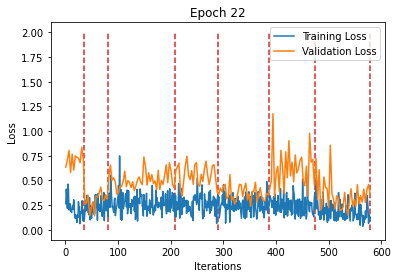

Train



Sequence:1, Seq Training Mean Loss: 0.23612149163252777, Seq Training Acc: 0.8897569444444444
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.20067824804120593, Seq Training Acc: 0.9180555555555555
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.25366756413865277, Seq Training Acc: 0.8848425196850394
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.24199568007777378, Seq Training Acc: 0.8936737804878049
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.24835836672291314, Seq Training Acc: 0.8898195876288659
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.289924709447499, Seq Training Acc: 0.8670977011494253
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.18353841446626645, Seq Training Acc: 0.9194711538461539
******************************************************************
Epoch:23, Epoch Training Loss Mean: 0.23874138295650482, Epoch Training Acc: 0.8933823529411765
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.45042472581068677, Seq Valid Acc: 0.8020833333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.2639612476030985, Seq Valid Acc: 0.8833333333333333



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.4404920297009604, Seq Valid Acc: 0.7849702380952381



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.47152720778076734, Seq Valid Acc: 0.7928240740740741



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4229525535395651, Seq Valid Acc: 0.8020833333333334



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.4814549612587896, Seq Valid Acc: 0.7737068965517241



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.26218412969918814, Seq Valid Acc: 0.8759191176470589
Epoch:23, Epoch Valid Mean Loss: 0.40328288078308105, Epoch Valid Acc: 0.8121744791666666
******************************************************************


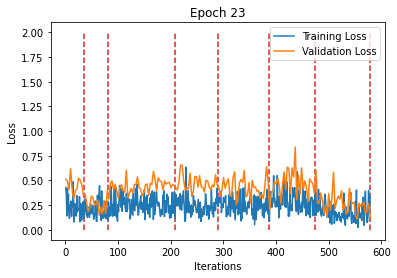

Train



Sequence:1, Seq Training Mean Loss: 0.2139668537096845, Seq Training Acc: 0.9053819444444444
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.20716111212968827, Seq Training Acc: 0.9083333333333333
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.24676780795722497, Seq Training Acc: 0.8973917322834646
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.23457831580464433, Seq Training Acc: 0.899390243902439
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2398470647863506, Seq Training Acc: 0.8985180412371134
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.2574137143533805, Seq Training Acc: 0.891882183908046
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.17363530900687552, Seq Training Acc: 0.9299879807692307
******************************************************************
Epoch:24, Epoch Training Loss Mean: 0.22719413042068481, Epoch Training Acc: 0.9042495674740484
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 1.0042252739270527, Seq Valid Acc: 0.5130208333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.3023110409577688, Seq Valid Acc: 0.8583333333333333



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.4656638048944019, Seq Valid Acc: 0.7738095238095238



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.4992493909818155, Seq Valid Acc: 0.7766203703703703



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4142956896261735, Seq Valid Acc: 0.8143939393939394



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.5235886162724989, Seq Valid Acc: 0.7327586206896551



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.35742825225872155, Seq Valid Acc: 0.8566176470588235
Epoch:24, Epoch Valid Mean Loss: 0.4720383584499359, Epoch Valid Acc: 0.7799479166666666
******************************************************************


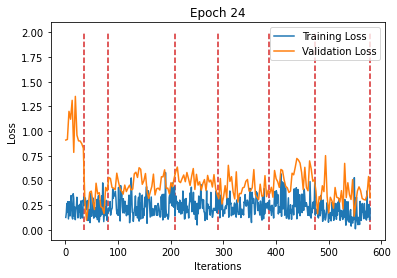

Train



Sequence:1, Seq Training Mean Loss: 0.21954782348540094, Seq Training Acc: 0.8975694444444444
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.22098706828223336, Seq Training Acc: 0.8986111111111111
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.25750650676685993, Seq Training Acc: 0.8809055118110236
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.2359951884463066, Seq Training Acc: 0.895579268292683
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.24312250992071996, Seq Training Acc: 0.8901417525773195
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.26229574479933443, Seq Training Acc: 0.8811063218390804
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.17975683198668635, Seq Training Acc: 0.9206730769230769
******************************************************************
Epoch:25, Epoch Training Loss Mean: 0.23356470465660095, Epoch Training Acc: 0.8941392733564014
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.7786066432793936, Seq Valid Acc: 0.6536458333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.267384480436643, Seq Valid Acc: 0.8791666666666667



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.5179594996429625, Seq Valid Acc: 0.7388392857142857



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.49969571828842163, Seq Valid Acc: 0.7858796296296297



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.42997352101586084, Seq Valid Acc: 0.803030303030303



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.724303779930904, Seq Valid Acc: 0.7122844827586207



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.3534600563785609, Seq Valid Acc: 0.8556985294117647
Epoch:25, Epoch Valid Mean Loss: 0.4990192949771881, Epoch Valid Acc: 0.77880859375
******************************************************************


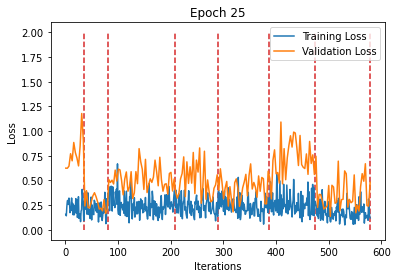

Train



Sequence:1, Seq Training Mean Loss: 0.221573607582185, Seq Training Acc: 0.9036458333333334
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2084492830766572, Seq Training Acc: 0.9111111111111111
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2346637604508813, Seq Training Acc: 0.8946850393700787
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.2335407975606802, Seq Training Acc: 0.8997713414634146
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.23511900917924555, Seq Training Acc: 0.8991623711340206
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.2682734472655702, Seq Training Acc: 0.8854166666666666
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.16291576113480216, Seq Training Acc: 0.9326923076923077
******************************************************************
Epoch:26, Epoch Training Loss Mean: 0.22387383878231049, Epoch Training Acc: 0.9034385813148789
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.4581635569532712, Seq Valid Acc: 0.8151041666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.2988383024930954, Seq Valid Acc: 0.8854166666666666



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.37766492473227636, Seq Valid Acc: 0.8333333333333334



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.4134501196719982, Seq Valid Acc: 0.8321759259259259



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.4017904292453419, Seq Valid Acc: 0.8229166666666666



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.4847977377217391, Seq Valid Acc: 0.7618534482758621



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.18906428292393684, Seq Valid Acc: 0.921875
Epoch:26, Epoch Valid Mean Loss: 0.36850011348724365, Epoch Valid Acc: 0.8391927083333334
******************************************************************


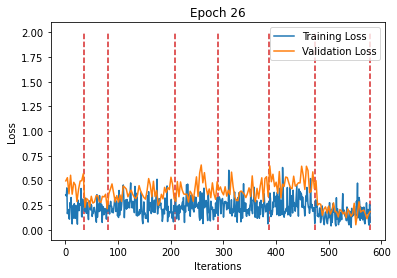

Train



Sequence:1, Seq Training Mean Loss: 0.2406246920840608, Seq Training Acc: 0.8975694444444444
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.21131306224399143, Seq Training Acc: 0.9076388888888889
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2569281535707121, Seq Training Acc: 0.8855807086614174
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.2318798529847366, Seq Training Acc: 0.8929115853658537
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.22297432834340125, Seq Training Acc: 0.9043170103092784
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.24752035313125315, Seq Training Acc: 0.889367816091954
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.17269348901195022, Seq Training Acc: 0.9227764423076923
******************************************************************
Epoch:27, Epoch Training Loss Mean: 0.22653721272945404, Epoch Training Acc: 0.8994917820069204
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5666717191537222, Seq Valid Acc: 0.7526041666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.28124349216620126, Seq Valid Acc: 0.8875



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.36106360526311965, Seq Valid Acc: 0.8422619047619048



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.4640128430393007, Seq Valid Acc: 0.7893518518518519



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.3673676053682963, Seq Valid Acc: 0.8428030303030303



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.46142383998837966, Seq Valid Acc: 0.7855603448275862



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.23593986823278315, Seq Valid Acc: 0.8952205882352942
Epoch:27, Epoch Valid Mean Loss: 0.37624016404151917, Epoch Valid Acc: 0.8336588541666666
******************************************************************


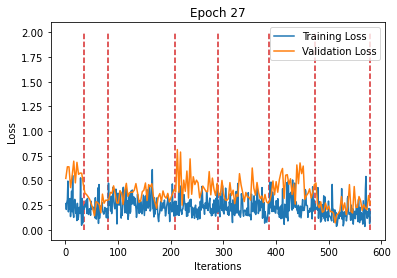

Train



Sequence:1, Seq Training Mean Loss: 0.20573663183798394, Seq Training Acc: 0.9140625
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.19492702235778173, Seq Training Acc: 0.9083333333333333
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.23298663898246494, Seq Training Acc: 0.9003444881889764
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.22376163776327923, Seq Training Acc: 0.9073932926829268
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.21735962134661133, Seq Training Acc: 0.9065721649484536
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.2488445157035329, Seq Training Acc: 0.8882902298850575
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.17327488023931018, Seq Training Acc: 0.9266826923076923
******************************************************************
Epoch:28, Epoch Training Loss Mean: 0.21603794395923615, Epoch Training Acc: 0.9067906574394463
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5125414753953615, Seq Valid Acc: 0.7682291666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.2676096091667811, Seq Valid Acc: 0.9145833333333333



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.3568110384401821, Seq Valid Acc: 0.8422619047619048



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.39510432327235184, Seq Valid Acc: 0.8287037037037037



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.33514145693995734, Seq Valid Acc: 0.8409090909090909



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.46969351275213833, Seq Valid Acc: 0.7683189655172413



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.27540411077001514, Seq Valid Acc: 0.8704044117647058
Epoch:28, Epoch Valid Mean Loss: 0.3638700246810913, Epoch Valid Acc: 0.8349609375
******************************************************************


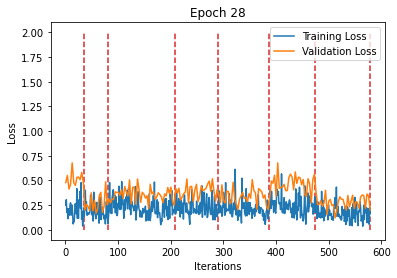

Train



Sequence:1, Seq Training Mean Loss: 0.18683108770185047, Seq Training Acc: 0.9236111111111112
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.2132504997154077, Seq Training Acc: 0.9138888888888889
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.24881286948449968, Seq Training Acc: 0.8919783464566929
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.21952332338181937, Seq Training Acc: 0.9066310975609756
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.24550320300244793, Seq Training Acc: 0.8901417525773195
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.24699018390356808, Seq Training Acc: 0.8843390804597702
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.17308662876558417, Seq Training Acc: 0.9230769230769231
******************************************************************
Epoch:29, Epoch Training Loss Mean: 0.2235732078552246, Epoch Training Acc: 0.9018706747404844
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.9205688387155533, Seq Valid Acc: 0.5963541666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.24559637308120727, Seq Valid Acc: 0.9083333333333333



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.4261465171972911, Seq Valid Acc: 0.8035714285714286



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.39270402049576797, Seq Valid Acc: 0.8136574074074074



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.3624568342259436, Seq Valid Acc: 0.8323863636363636



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.4205199772941655, Seq Valid Acc: 0.8146551724137931



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.431550767930115, Seq Valid Acc: 0.828125
Epoch:29, Epoch Valid Mean Loss: 0.4274001121520996, Epoch Valid Acc: 0.8111979166666666
******************************************************************


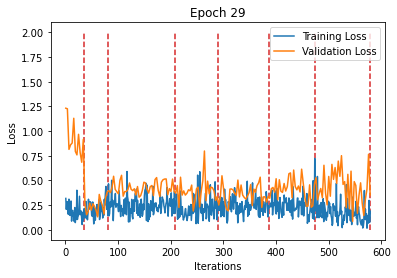

Train



Sequence:1, Seq Training Mean Loss: 0.19267915106481975, Seq Training Acc: 0.9149305555555556
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.22407683812909657, Seq Training Acc: 0.9006944444444445
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.2305800538715415, Seq Training Acc: 0.8954232283464567
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.22446193282560603, Seq Training Acc: 0.9001524390243902
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.23736716315303882, Seq Training Acc: 0.8946520618556701
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.2577754396131669, Seq Training Acc: 0.8886494252873564
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.1565091969588628, Seq Training Acc: 0.9302884615384616
******************************************************************
Epoch:30, Epoch Training Loss Mean: 0.2187499850988388, Epoch Training Acc: 0.9028438581314879
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6842283954222997, Seq Valid Acc: 0.6223958333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.24873683353265127, Seq Valid Acc: 0.8875



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.37874483068784076, Seq Valid Acc: 0.8236607142857143



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.42688443815266647, Seq Valid Acc: 0.8101851851851852



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.328459615057165, Seq Valid Acc: 0.8560606060606061



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.42709005238681, Seq Valid Acc: 0.802801724137931



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.273395333219977, Seq Valid Acc: 0.8630514705882353
Epoch:30, Epoch Valid Mean Loss: 0.3744540214538574, Epoch Valid Acc: 0.8235677083333334
******************************************************************


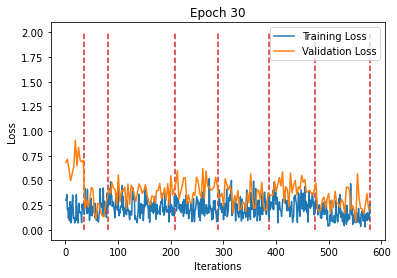

Train



Sequence:1, Seq Training Mean Loss: 0.19421808876925045, Seq Training Acc: 0.9166666666666666
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.19114564822779762, Seq Training Acc: 0.9104166666666667
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.230391492289821, Seq Training Acc: 0.8973917322834646
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.21529258760373768, Seq Training Acc: 0.9024390243902439
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.21463298348268284, Seq Training Acc: 0.9081829896907216
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.24023913223853058, Seq Training Acc: 0.8933189655172413
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.15291757150911367, Seq Training Acc: 0.9356971153846154
******************************************************************
Epoch:31, Epoch Training Loss Mean: 0.20783866941928864, Epoch Training Acc: 0.9084126297577855
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6402154415845871, Seq Valid Acc: 0.6588541666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.2864633450905482, Seq Valid Acc: 0.8958333333333334



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.41159282802116304, Seq Valid Acc: 0.8058035714285714



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.4434689117802514, Seq Valid Acc: 0.7905092592592593



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.37317005161083106, Seq Valid Acc: 0.8276515151515151



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.4773071850168294, Seq Valid Acc: 0.7877155172413793



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.2866925470092717, Seq Valid Acc: 0.8630514705882353
Epoch:31, Epoch Valid Mean Loss: 0.4017925262451172, Epoch Valid Acc: 0.8126627604166666
******************************************************************


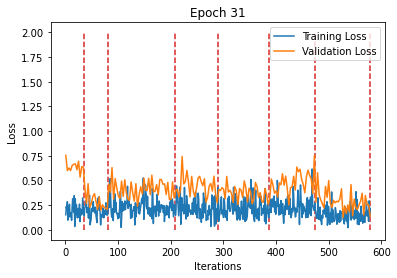

Train



Sequence:1, Seq Training Mean Loss: 0.18930061037341753, Seq Training Acc: 0.9184027777777778
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.19197774885429275, Seq Training Acc: 0.9125
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.22112866362014155, Seq Training Acc: 0.9010826771653543
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.2234840927781855, Seq Training Acc: 0.9051067073170732
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.22322584043458565, Seq Training Acc: 0.9010953608247423
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.23523395491399984, Seq Training Acc: 0.8926005747126436
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.15753607580868098, Seq Training Acc: 0.9399038461538461
******************************************************************
Epoch:32, Epoch Training Loss Mean: 0.2082437127828598, Epoch Training Acc: 0.9093317474048442
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6389952773849169, Seq Valid Acc: 0.6692708333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.28013797998428347, Seq Valid Acc: 0.8708333333333333



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.3473499977872485, Seq Valid Acc: 0.8422619047619048



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.46289180826257775, Seq Valid Acc: 0.7685185185185185



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.39275676463589526, Seq Valid Acc: 0.8172348484848485



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.4806897532323311, Seq Valid Acc: 0.7758620689655172



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.21385656187639518, Seq Valid Acc: 0.8998161764705882
Epoch:32, Epoch Valid Mean Loss: 0.38087964057922363, Epoch Valid Acc: 0.8191731770833334
******************************************************************


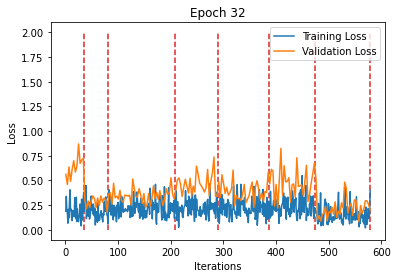

Train



Sequence:1, Seq Training Mean Loss: 0.19909103173348638, Seq Training Acc: 0.9105902777777778
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.19864628844790988, Seq Training Acc: 0.9159722222222222
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.20270033526842987, Seq Training Acc: 0.9111712598425197
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.21098730186136758, Seq Training Acc: 0.9085365853658537
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.20867640133371057, Seq Training Acc: 0.9097938144329897
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.23239904714898132, Seq Training Acc: 0.8936781609195402
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.15125466134542456, Seq Training Acc: 0.9305889423076923
******************************************************************
Epoch:33, Epoch Training Loss Mean: 0.1995520144701004, Epoch Training Acc: 0.9117647058823529
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.4196006506681442, Seq Valid Acc: 0.8020833333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.25239976147810617, Seq Valid Acc: 0.9041666666666667



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.30046346890074865, Seq Valid Acc: 0.8772321428571429



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.4505655820722933, Seq Valid Acc: 0.7951388888888888



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.36327564535718976, Seq Valid Acc: 0.8428030303030303



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.46401377587482845, Seq Valid Acc: 0.78125



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.20334807367009275, Seq Valid Acc: 0.9090073529411765
Epoch:33, Epoch Valid Mean Loss: 0.34356391429901123, Epoch Valid Acc: 0.8483072916666666
******************************************************************


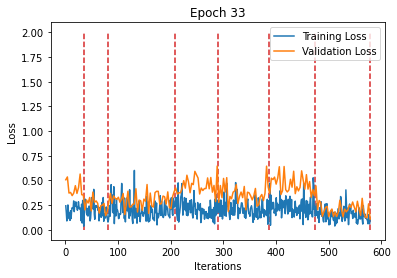

Train



Sequence:1, Seq Training Mean Loss: 0.20613813172611925, Seq Training Acc: 0.9157986111111112
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.17088217602835762, Seq Training Acc: 0.9256944444444445
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.21207146167637794, Seq Training Acc: 0.9037893700787402
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.19059116238864457, Seq Training Acc: 0.9127286585365854
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.2051401429415978, Seq Training Acc: 0.9056056701030928
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.21928962354344883, Seq Training Acc: 0.9001436781609196
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.15173500194214284, Seq Training Acc: 0.9341947115384616
******************************************************************
Epoch:34, Epoch Training Loss Mean: 0.19451463222503662, Epoch Training Acc: 0.9127378892733564
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5023399218916893, Seq Valid Acc: 0.7604166666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.27265429496765137, Seq Valid Acc: 0.88125



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.32403841330891564, Seq Valid Acc: 0.8467261904761905



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.41596836072427257, Seq Valid Acc: 0.8229166666666666



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.3297788103421529, Seq Valid Acc: 0.8579545454545454



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.42919215354426155, Seq Valid Acc: 0.7877155172413793



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.24162916269372492, Seq Valid Acc: 0.8805147058823529
Epoch:34, Epoch Valid Mean Loss: 0.34637144207954407, Epoch Valid Acc: 0.8396809895833334
******************************************************************


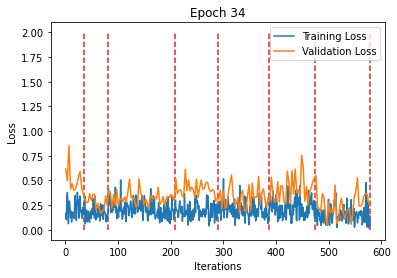

Train



Sequence:1, Seq Training Mean Loss: 0.19670140370726585, Seq Training Acc: 0.9131944444444444
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.18037218186590406, Seq Training Acc: 0.9236111111111112
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.18803288749470484, Seq Training Acc: 0.9180610236220472
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.19332324250078783, Seq Training Acc: 0.9180640243902439
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.20966966434852363, Seq Training Acc: 0.9072164948453608
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.21536669023763175, Seq Training Acc: 0.9048132183908046
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.13456637494695875, Seq Training Acc: 0.9411057692307693
******************************************************************
Epoch:35, Epoch Training Loss Mean: 0.18685197830200195, Epoch Training Acc: 0.9185229238754326
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.4328998848795891, Seq Valid Acc: 0.8151041666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.2455998679002126, Seq Valid Acc: 0.8958333333333334



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.27111344997371944, Seq Valid Acc: 0.8712797619047619



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.38341994528417234, Seq Valid Acc: 0.8194444444444444



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.3015594897848187, Seq Valid Acc: 0.8503787878787878



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.38667250501698464, Seq Valid Acc: 0.8200431034482759



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.18716232171830008, Seq Valid Acc: 0.9136029411764706
Epoch:35, Epoch Valid Mean Loss: 0.3028457462787628, Epoch Valid Acc: 0.8585611979166666
******************************************************************


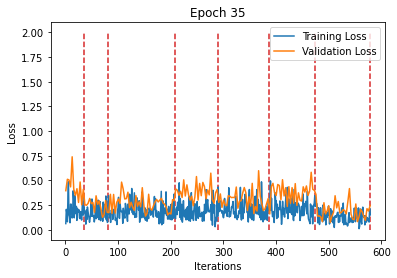

Train



Sequence:1, Seq Training Mean Loss: 0.15472661227815682, Seq Training Acc: 0.9331597222222222
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.20227835128704708, Seq Training Acc: 0.9097222222222222
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.18912418210130977, Seq Training Acc: 0.9178149606299213
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.19692751211000653, Seq Training Acc: 0.9119664634146342
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.18555435280978066, Seq Training Acc: 0.9181701030927835
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.21695442917360658, Seq Training Acc: 0.9026580459770115
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.1311341754357832, Seq Training Acc: 0.9426081730769231
******************************************************************
Epoch:36, Epoch Training Loss Mean: 0.1822686344385147, Epoch Training Acc: 0.9195501730103807
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.48704634855190915, Seq Valid Acc: 0.7708333333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.23385374049345653, Seq Valid Acc: 0.9



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.31416916687573704, Seq Valid Acc: 0.859375



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.4107677936553955, Seq Valid Acc: 0.8067129629629629



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.35243712772022595, Seq Valid Acc: 0.8371212121212122



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.46922308823158, Seq Valid Acc: 0.7801724137931034



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.2249725602348061, Seq Valid Acc: 0.9053308823529411
Epoch:36, Epoch Valid Mean Loss: 0.3464852273464203, Epoch Valid Acc: 0.8419596354166666
******************************************************************


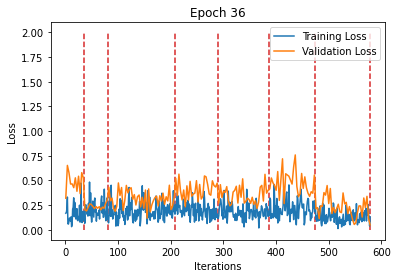

Train



Sequence:1, Seq Training Mean Loss: 0.17572086159553793, Seq Training Acc: 0.9288194444444444
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.19342252959807713, Seq Training Acc: 0.9076388888888889
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.20192377638863765, Seq Training Acc: 0.9126476377952756
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.1797037952829425, Seq Training Acc: 0.9211128048780488
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.19441664668241726, Seq Training Acc: 0.9146262886597938
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.20949519536961084, Seq Training Acc: 0.9040948275862069
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.13305090045413145, Seq Training Acc: 0.9429086538461539
******************************************************************
Epoch:37, Epoch Training Loss Mean: 0.1839650273323059, Epoch Training Acc: 0.9189554498269896
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5456006824970245, Seq Valid Acc: 0.7369791666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.26984712680180867, Seq Valid Acc: 0.8854166666666666



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.28514110084090916, Seq Valid Acc: 0.8720238095238095



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.3394290970431434, Seq Valid Acc: 0.8414351851851852



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.2659726806662299, Seq Valid Acc: 0.8806818181818182



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.38126976993577233, Seq Valid Acc: 0.8168103448275862



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.2905117803636719, Seq Valid Acc: 0.8648897058823529
Epoch:37, Epoch Valid Mean Loss: 0.3200351297855377, Epoch Valid Acc: 0.8522135416666666
******************************************************************


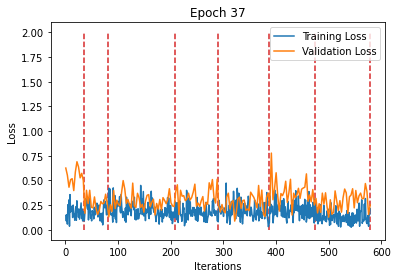

Train



Sequence:1, Seq Training Mean Loss: 0.13795978596640956, Seq Training Acc: 0.9444444444444444
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.1780330561929279, Seq Training Acc: 0.9180555555555555
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.18449364247636532, Seq Training Acc: 0.9200295275590551
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.18296724085400745, Seq Training Acc: 0.9176829268292683
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.1869723023942758, Seq Training Acc: 0.9159149484536082
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.20111053077311353, Seq Training Acc: 0.9148706896551724
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.13953368892320073, Seq Training Acc: 0.9365985576923077
******************************************************************
Epoch:38, Epoch Training Loss Mean: 0.1757032573223114, Epoch Training Acc: 0.9225778546712803
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.49317454546689987, Seq Valid Acc: 0.7604166666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.23826381762822468, Seq Valid Acc: 0.9125



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.2934458811013472, Seq Valid Acc: 0.8616071428571429



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.3704491875789784, Seq Valid Acc: 0.8460648148148148



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.3200073860811465, Seq Valid Acc: 0.8503787878787878



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.43540992305196563, Seq Valid Acc: 0.7984913793103449



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.22945389063919291, Seq Valid Acc: 0.8961397058823529
Epoch:38, Epoch Valid Mean Loss: 0.3271222412586212, Epoch Valid Acc: 0.8517252604166666
******************************************************************


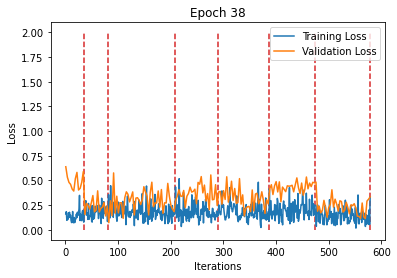

Train



Sequence:1, Seq Training Mean Loss: 0.19112998495499292, Seq Training Acc: 0.9201388888888888
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.164098964465989, Seq Training Acc: 0.9284722222222223
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.18352148825610717, Seq Training Acc: 0.9224901574803149
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.16143483541360715, Seq Training Acc: 0.9298780487804879
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.17925448838582972, Seq Training Acc: 0.9201030927835051
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.2131792780482906, Seq Training Acc: 0.9044540229885057
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.1299981357028278, Seq Training Acc: 0.9438100961538461
******************************************************************
Epoch:39, Epoch Training Loss Mean: 0.17346730828285217, Epoch Training Acc: 0.9245782871972318
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.590087540447712, Seq Valid Acc: 0.7291666666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.20860751668612162, Seq Valid Acc: 0.9229166666666667



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.26033341884613037, Seq Valid Acc: 0.8898809523809523



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.3946219759958762, Seq Valid Acc: 0.8298611111111112



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.32478033141656354, Seq Valid Acc: 0.8456439393939394



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.39222663692359266, Seq Valid Acc: 0.8103448275862069



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.2826598562738475, Seq Valid Acc: 0.8786764705882353
Epoch:39, Epoch Valid Mean Loss: 0.3307380974292755, Epoch Valid Acc: 0.8523763020833334
******************************************************************


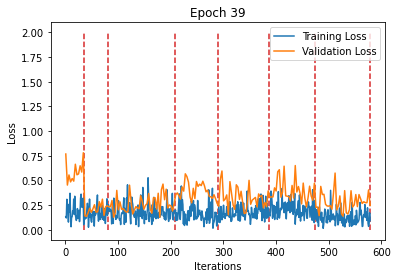

Train



Sequence:1, Seq Training Mean Loss: 0.14747340304570067, Seq Training Acc: 0.9270833333333334
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.1735038140581714, Seq Training Acc: 0.9138888888888889
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.1775830641506225, Seq Training Acc: 0.9234744094488189
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.18063780974324156, Seq Training Acc: 0.9157774390243902
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.17959320364692777, Seq Training Acc: 0.9201030927835051
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.20014687516223426, Seq Training Acc: 0.9116379310344828
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.1402643621684267, Seq Training Acc: 0.9399038461538461
******************************************************************
Epoch:40, Epoch Training Loss Mean: 0.1728423535823822, Epoch Training Acc: 0.922469723183391
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.6267397354046503, Seq Valid Acc: 0.6979166666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.2329036811987559, Seq Valid Acc: 0.9166666666666666



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.31650543053235325, Seq Valid Acc: 0.8630952380952381



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.38337002804985754, Seq Valid Acc: 0.8206018518518519



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.31186767825574585, Seq Valid Acc: 0.8570075757575758



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.4023902231249316, Seq Valid Acc: 0.8038793103448276



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.2579005075728192, Seq Valid Acc: 0.8851102941176471
Epoch:40, Epoch Valid Mean Loss: 0.34056365489959717, Epoch Valid Acc: 0.8448893229166666
******************************************************************


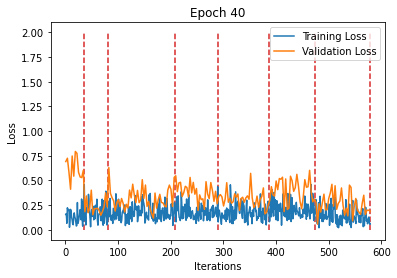

Train



Sequence:1, Seq Training Mean Loss: 0.1555213217313091, Seq Training Acc: 0.9348958333333334
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.17544386982917787, Seq Training Acc: 0.9222222222222223
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.1761256535574207, Seq Training Acc: 0.9212598425196851
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.16821341034842702, Seq Training Acc: 0.926829268292683
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.17362394314451315, Seq Training Acc: 0.9220360824742269
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.19577406515934687, Seq Training Acc: 0.9123563218390804
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.10665607219114183, Seq Training Acc: 0.9579326923076923
******************************************************************
Epoch:41, Epoch Training Loss Mean: 0.16370466351509094, Epoch Training Acc: 0.9283628892733564
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.5921184420585632, Seq Valid Acc: 0.7109375



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.23352858225504558, Seq Valid Acc: 0.89375



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.26380406763582004, Seq Valid Acc: 0.8816964285714286



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.35968533213491793, Seq Valid Acc: 0.8587962962962963



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.30400753969495947, Seq Valid Acc: 0.8664772727272727



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.35882250296658486, Seq Valid Acc: 0.8286637931034483



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.24627751462599812, Seq Valid Acc: 0.890625
Epoch:41, Epoch Valid Mean Loss: 0.3135997951030731, Epoch Valid Acc: 0.8597005208333334
******************************************************************


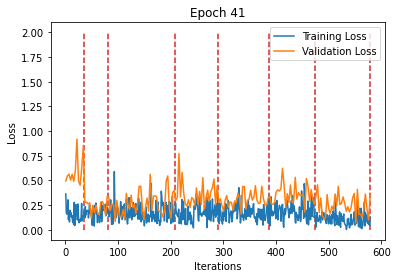

Train



Sequence:1, Seq Training Mean Loss: 0.1378199646456374, Seq Training Acc: 0.9418402777777778
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.16836137423912684, Seq Training Acc: 0.9305555555555556
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.17279431476133075, Seq Training Acc: 0.922736220472441
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.17387659672829436, Seq Training Acc: 0.9195884146341463
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.1786913873301339, Seq Training Acc: 0.9139819587628866
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.19161948005015822, Seq Training Acc: 0.9137931034482759
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.11201070870559376, Seq Training Acc: 0.9510216346153846
******************************************************************
Epoch:42, Epoch Training Loss Mean: 0.16331075131893158, Epoch Training Acc: 0.9263624567474048
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.44486180941263836, Seq Valid Acc: 0.7994791666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.25180457135041556, Seq Valid Acc: 0.9041666666666667



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.2613566794565746, Seq Valid Acc: 0.8831845238095238



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.34890017520498345, Seq Valid Acc: 0.8391203703703703



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.37859703374631476, Seq Valid Acc: 0.8191287878787878



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.3921324549050167, Seq Valid Acc: 0.822198275862069



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.22927482031724034, Seq Valid Acc: 0.8897058823529411
Epoch:42, Epoch Valid Mean Loss: 0.3186124265193939, Epoch Valid Acc: 0.8543294270833334
******************************************************************


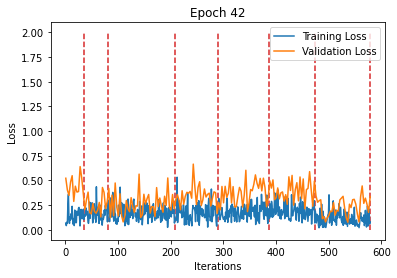

Train



Sequence:1, Seq Training Mean Loss: 0.14213926314065853, Seq Training Acc: 0.9348958333333334
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.14486183130906688, Seq Training Acc: 0.9291666666666667
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.1522985916496731, Seq Training Acc: 0.9313484251968503
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.17586964536912558, Seq Training Acc: 0.9256859756097561
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.17107486091170115, Seq Training Acc: 0.9259020618556701
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.18604561814974094, Seq Training Acc: 0.9198994252873564
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.10699934986097595, Seq Training Acc: 0.9579326923076923
******************************************************************
Epoch:43, Epoch Training Loss Mean: 0.1545107066631317, Epoch Training Acc: 0.932742214532872
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.4473082820574443, Seq Valid Acc: 0.78125



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.23839367777109147, Seq Valid Acc: 0.9020833333333333



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.28063133500871207, Seq Valid Acc: 0.8683035714285714



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.3039263492381131, Seq Valid Acc: 0.8831018518518519



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.2937942169832461, Seq Valid Acc: 0.8806818181818182



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.3553639434534928, Seq Valid Acc: 0.8297413793103449



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.2064174099222702, Seq Valid Acc: 0.9007352941176471
Epoch:43, Epoch Valid Mean Loss: 0.2914327383041382, Epoch Valid Acc: 0.86962890625
******************************************************************


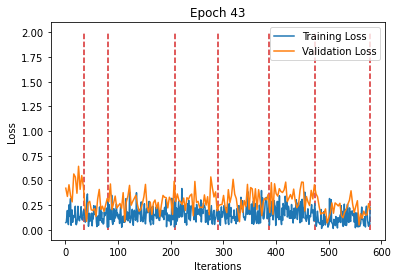

Train



Sequence:1, Seq Training Mean Loss: 0.1352867233929121, Seq Training Acc: 0.9418402777777778
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.14860487629969915, Seq Training Acc: 0.9368055555555556
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.15982986872238436, Seq Training Acc: 0.9232283464566929
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.15957460911353913, Seq Training Acc: 0.9294969512195121
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.15653885425711722, Seq Training Acc: 0.9304123711340206
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.17737852405200058, Seq Training Acc: 0.9242097701149425
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.11033069465954143, Seq Training Acc: 0.9558293269230769
******************************************************************
Epoch:44, Epoch Training Loss Mean: 0.15057379007339478, Epoch Training Acc: 0.9335532006920415
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.470471349855264, Seq Valid Acc: 0.8046875



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.24871529638767242, Seq Valid Acc: 0.89375



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.24998297276241438, Seq Valid Acc: 0.890625



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.3152238803881186, Seq Valid Acc: 0.8495370370370371



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.3099096728996797, Seq Valid Acc: 0.8503787878787878



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.4283050519639048, Seq Valid Acc: 0.7920258620689655



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.2322639662991552, Seq Valid Acc: 0.8924632352941176
Epoch:44, Epoch Valid Mean Loss: 0.30693519115448, Epoch Valid Acc: 0.8582356770833334
******************************************************************


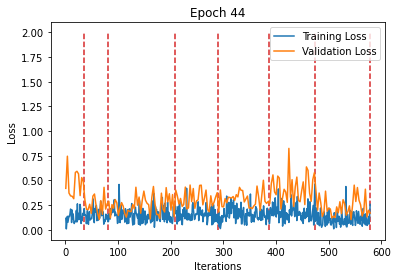

Train



Sequence:1, Seq Training Mean Loss: 0.1349460512606634, Seq Training Acc: 0.9392361111111112
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.14707262996170256, Seq Training Acc: 0.9409722222222222
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.16476540620930083, Seq Training Acc: 0.9244586614173228
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.15844141673750994, Seq Training Acc: 0.9294969512195121
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.1609302002590956, Seq Training Acc: 0.9259020618556701
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.18136755766711016, Seq Training Acc: 0.9177442528735632
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.106976189578955, Seq Training Acc: 0.9543269230769231
******************************************************************
Epoch:45, Epoch Training Loss Mean: 0.15209077298641205, Epoch Training Acc: 0.9319852941176471
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.4531002789735794, Seq Valid Acc: 0.7890625



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.2447668711344401, Seq Valid Acc: 0.8854166666666666



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.25174256236780257, Seq Valid Acc: 0.8958333333333334



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.31154668772662125, Seq Valid Acc: 0.875



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.29219305921684613, Seq Valid Acc: 0.8664772727272727



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.39520523363146287, Seq Valid Acc: 0.8297413793103449



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.248718911453205, Seq Valid Acc: 0.8832720588235294
Epoch:45, Epoch Valid Mean Loss: 0.3002782166004181, Epoch Valid Acc: 0.8681640625
******************************************************************


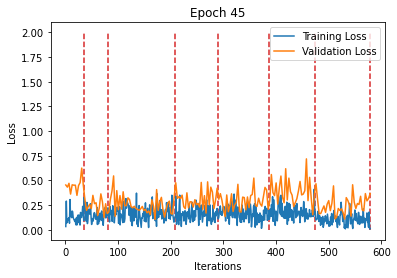

Train



Sequence:1, Seq Training Mean Loss: 0.1315608092894157, Seq Training Acc: 0.9435763888888888
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.17045352359612784, Seq Training Acc: 0.9194444444444444
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.16825077305804556, Seq Training Acc: 0.9247047244094488
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.15895830858044507, Seq Training Acc: 0.9329268292682927
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.15800572359531195, Seq Training Acc: 0.9271907216494846
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.1666651982171782, Seq Training Acc: 0.9274425287356322
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.11747978220228106, Seq Training Acc: 0.9486177884615384
******************************************************************
Epoch:46, Epoch Training Loss Mean: 0.1537255346775055, Epoch Training Acc: 0.9317690311418685
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.41088136782248813, Seq Valid Acc: 0.8072916666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.22393394311269124, Seq Valid Acc: 0.9



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.22542156270217328, Seq Valid Acc: 0.8988095238095238



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.3456329957202629, Seq Valid Acc: 0.8460648148148148



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.27358854042761255, Seq Valid Acc: 0.8806818181818182



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.3723812627381292, Seq Valid Acc: 0.8265086206896551



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.24266881780589328, Seq Valid Acc: 0.8933823529411765
Epoch:46, Epoch Valid Mean Loss: 0.2873312532901764, Epoch Valid Acc: 0.8707682291666666
******************************************************************


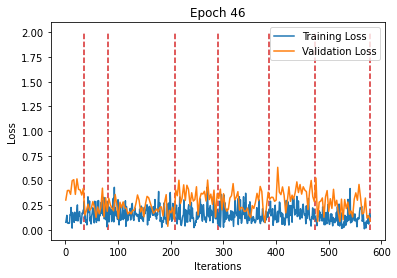

Train



Sequence:1, Seq Training Mean Loss: 0.1444431809294555, Seq Training Acc: 0.9383680555555556
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.1573461275961664, Seq Training Acc: 0.925
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.1488019251741293, Seq Training Acc: 0.9288877952755905
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.17793700267083762, Seq Training Acc: 0.9184451219512195
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.15897018477781533, Seq Training Acc: 0.930090206185567
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.17730399559455357, Seq Training Acc: 0.9202586206896551
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.09803948320376758, Seq Training Acc: 0.9579326923076923
******************************************************************
Epoch:47, Epoch Training Loss Mean: 0.15019181370735168, Epoch Training Acc: 0.9318230968858131
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.4941161225239436, Seq Valid Acc: 0.7682291666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.24007309178511302, Seq Valid Acc: 0.8895833333333333



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.25202847325376104, Seq Valid Acc: 0.8787202380952381



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.3073488617384875, Seq Valid Acc: 0.8622685185185185



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.30229744586077606, Seq Valid Acc: 0.8645833333333334



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.4043988215512243, Seq Valid Acc: 0.822198275862069



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.2577108943506199, Seq Valid Acc: 0.8823529411764706
Epoch:47, Epoch Valid Mean Loss: 0.3066648840904236, Epoch Valid Acc: 0.8600260416666666
******************************************************************


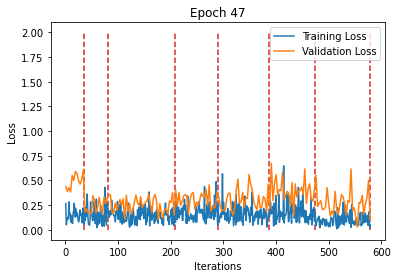

Train



Sequence:1, Seq Training Mean Loss: 0.14716898194617695, Seq Training Acc: 0.9296875
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.16206846253739463, Seq Training Acc: 0.9236111111111112
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.15314776514928172, Seq Training Acc: 0.9308562992125984
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.1447524484701273, Seq Training Acc: 0.9302591463414634
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.1656222777805992, Seq Training Acc: 0.9252577319587629
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.17057818623966184, Seq Training Acc: 0.9292385057471264
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.09787273238180205, Seq Training Acc: 0.9642427884615384
******************************************************************
Epoch:48, Epoch Training Loss Mean: 0.14705027639865875, Epoch Training Acc: 0.9349589100346021
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.4724894016981125, Seq Valid Acc: 0.7734375



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.19492711126804352, Seq Valid Acc: 0.9208333333333333



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.21902401301832425, Seq Valid Acc: 0.9017857142857143



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.33413154825016306, Seq Valid Acc: 0.8634259259259259



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.29837601880232495, Seq Valid Acc: 0.8626893939393939



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.35798164585541037, Seq Valid Acc: 0.8426724137931034



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.2691374333465801, Seq Valid Acc: 0.8722426470588235
Epoch:48, Epoch Valid Mean Loss: 0.2926712930202484, Epoch Valid Acc: 0.8689778645833334
******************************************************************


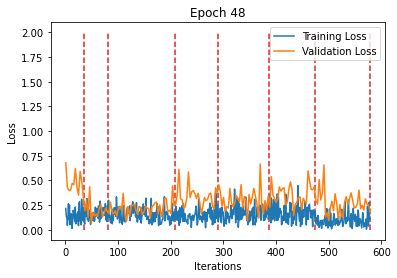

Train



Sequence:1, Seq Training Mean Loss: 0.11231291252705786, Seq Training Acc: 0.9513888888888888
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.14726363056235844, Seq Training Acc: 0.9340277777777778
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.1556538914249638, Seq Training Acc: 0.9298720472440944
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.150567921423694, Seq Training Acc: 0.9336890243902439
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.1651112835892697, Seq Training Acc: 0.9233247422680413
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.16955123833198657, Seq Training Acc: 0.9242097701149425
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.10252147893278071, Seq Training Acc: 0.9540264423076923
******************************************************************
Epoch:49, Epoch Training Loss Mean: 0.14569848775863647, Epoch Training Acc: 0.9344723183391004
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.46267038335402805, Seq Valid Acc: 0.7708333333333334



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.21443686385949454, Seq Valid Acc: 0.9104166666666667



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.25019033572503496, Seq Valid Acc: 0.875



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.3133036990960439, Seq Valid Acc: 0.8657407407407407



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.272263613614169, Seq Valid Acc: 0.8740530303030303



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.4198874343058159, Seq Valid Acc: 0.8178879310344828



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.23615523055195808, Seq Valid Acc: 0.8933823529411765
Epoch:49, Epoch Valid Mean Loss: 0.29649218916893005, Epoch Valid Acc: 0.8644205729166666
******************************************************************


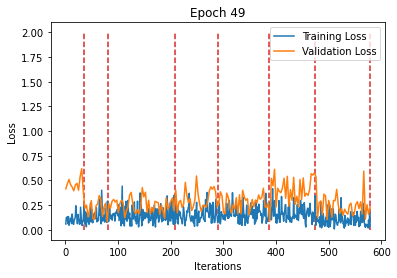

Train



Sequence:1, Seq Training Mean Loss: 0.153825165083011, Seq Training Acc: 0.9366319444444444
******************************************************************



Sequence:2, Seq Training Mean Loss: 0.1847710692220264, Seq Training Acc: 0.9173611111111111
******************************************************************



Sequence:3, Seq Training Mean Loss: 0.16928817447656253, Seq Training Acc: 0.9234744094488189
******************************************************************



Sequence:4, Seq Training Mean Loss: 0.1534576654525065, Seq Training Acc: 0.9317835365853658
******************************************************************



Sequence:5, Seq Training Mean Loss: 0.15534585929408515, Seq Training Acc: 0.9326675257731959
******************************************************************



Sequence:6, Seq Training Mean Loss: 0.15758943206619944, Seq Training Acc: 0.9281609195402298
******************************************************************



Sequence:7, Seq Training Mean Loss: 0.09798093924585444, Seq Training Acc: 0.9591346153846154
******************************************************************
Epoch:50, Epoch Training Loss Mean: 0.1503535807132721, Epoch Training Acc: 0.9336613321799307
******************************************************************
Validation



******************************************************************
Sequence:1, Seq Valid Mean Loss: 0.4599868555863698, Seq Valid Acc: 0.7916666666666666



******************************************************************
Sequence:2, Seq Valid Mean Loss: 0.20319499621788661, Seq Valid Acc: 0.90625



******************************************************************
Sequence:3, Seq Valid Mean Loss: 0.2963055581563995, Seq Valid Acc: 0.859375



******************************************************************
Sequence:4, Seq Valid Mean Loss: 0.328690313078739, Seq Valid Acc: 0.8668981481481481



******************************************************************
Sequence:5, Seq Valid Mean Loss: 0.2966708698959062, Seq Valid Acc: 0.8778409090909091



******************************************************************
Sequence:6, Seq Valid Mean Loss: 0.3808033512584094, Seq Valid Acc: 0.8200431034482759



******************************************************************
Sequence:7, Seq Valid Mean Loss: 0.25316859211991816, Seq Valid Acc: 0.8814338235294118
Epoch:50, Epoch Valid Mean Loss: 0.3090021312236786, Epoch Valid Acc: 0.8610026041666666
******************************************************************


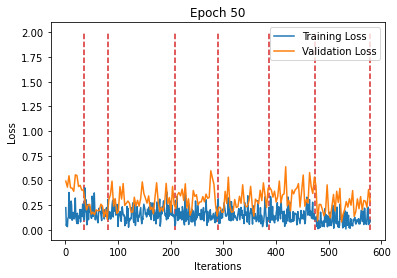


Save Model
Finished Training


In [24]:
if run_train:
    writer = SummaryWriter('runs/008_optunav2_32ref')
    max_iter_per_seq = 150
    # 训练迭代总步数
    num_train_iter_per_epoch = 0
    num_train_iterations = [] # For plot parting line
    num_train_iterations_per_dl = [max_iter_per_seq if len(dl)>= max_iter_per_seq else len(dl) for dl in train_dls]
    for seq_dataloaders in dataloaders:
        if len(seq_dataloaders[train_dl_idx]) <= max_iter_per_seq:
            num_train_iter_per_epoch += len(seq_dataloaders[train_dl_idx])
        else:
            num_train_iter_per_epoch += max_iter_per_seq
        num_train_iterations.append(num_train_iter_per_epoch)
    print("Total Train Iterations: ",num_train_iter_per_epoch)
    print("Total Train Iterations List: ",num_train_iterations)
        
    # 训练迭代总步数为验证迭代总步数的3倍
    num_val_iterations = [int(number / 3) for number in num_train_iterations]
    num_val_iter_per_epoch = num_val_iterations[-1]
    
    # iterations in every seq
    num_val_iter_per_seq = []
    num_val_iter_per_seq.append(num_val_iterations[0])
    for i in range(len(num_val_iterations)-1):
        diff = num_val_iterations[i+1] - num_val_iterations[i] # The latter minus the former
        num_val_iter_per_seq.append(diff)
        
    print("Valid iterations per seq: ",num_val_iter_per_seq)
        
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,eps=1e-08)

    scheduler = OneCycleLR(optimizer, num_train_iter_per_epoch, num_epochs, min_lr_factor=min_lr_factor)
    scheduler.step(epoch=0)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    loss_min = 0.
    
    for epoch in tqdm(range(1,num_epochs+1)):

        print('Train')

        model.train()
        
        running_corrects = 0

        train_loss_array = np.zeros(num_train_iter_per_epoch, dtype=np.single)

        # mse_y = torch.zeros(batch_sizes[0]//2).to(device)
        
        i = 0
        seq_idx = 1
        for (refs, train_dl, max_num) in zip(refs_list, train_dls, num_train_iterations_per_dl):
            # obtain the refs in every seq
            
            curr_train_dl = train_dl

            curr_refs = refs.float().to(device)

            # Training
            dl_iter = iter(curr_train_dl)
            
            # This two only used to compute the loss and acc in every Sequence
            running_loss = 0
            corrects = 0
            for idx in tqdm(range(max_num)):
                if idx >= max_iter_per_seq:
                    break
                try:
                    img1, img2, targets = next(dl_iter)

                except (StopIteration, TypeError):
                    dl_iter = iter(curr_train_dl)
                    img1, img2, targets = next(dl_iter)
                
                scheduler.zero_grad()

                img1 = img1.float().to(device)
                img2 = img2.float().to(device)
                targets = targets.view(-1)
                targets = targets.float().to(device)

                # forward pass
                loss, preds = model.compute_loss(img1, img2, curr_refs, targets)
                
                loss.backward()
                
                running_loss += loss.item()
                corrects += torch.sum(preds == targets)
                running_corrects += torch.sum(preds == targets)

                train_loss_array[i] = loss.cpu().detach().numpy()
               
                
                # record loss and accuracy per iteration
                c = torch.sum(preds == targets)
                acc = int(c) / img1.size(0)
                writer.add_scalar('Train/Loss per Iteration',train_loss_array[i], ((epoch - 1) * num_train_iter_per_epoch)+ i)
                writer.add_scalar('Train/Acc per Iteration',acc, ((epoch - 1) * num_train_iter_per_epoch)+ i)
                
                # Record the lr
                curr_lr = get_lr(optimizer)
                writer.add_scalar('Train/Learning Rate',curr_lr , ((epoch - 1) * num_train_iter_per_epoch)+ i)
                
                i += 1
                scheduler.step()
            
            # record loss and accuracy in every train dataloader (namely every Sequence)
            #seq_train_mean_loss = running_loss / len(curr_train_dl)
            #seq_train_acc = int(corrects) / (len(curr_train_dl) * img1.size(0))
            seq_train_mean_loss = running_loss / max_num
            seq_train_acc = int(corrects) / (max_num * img1.size(0))
            
            print("Sequence:{}, Seq Training Mean Loss: {}, Seq Training Acc: {}".format(seq_idx, seq_train_mean_loss, seq_train_acc))
            print("******************************************************************")
            # Record the loss and acc in every Seq in Tensorboard
            writer.add_scalar('Train/Seq Training Mean Loss',seq_train_mean_loss, (epoch - 1) * len(train_dls) + seq_idx)
            writer.add_scalar('Train/Seq Training Accuracy', seq_train_acc, (epoch - 1) * len(train_dls) + seq_idx)
            writer.add_scalar('Train/Seq Error Rate',1 - seq_train_acc, (epoch - 1) * len(train_dls) + seq_idx)
            
            seq_idx += 1
            
        # after one epoch update scheduler   
        # Plot lr policy
        curr_lr = get_lr(optimizer)
        writer.add_scalar('Train/Learning Rate Policy',curr_lr , epoch)
        writer.flush()
            
        # record loss and accuracy in every epoch (namely 6 Sequences)
        epoch_train_mean_loss = train_loss_array.mean()  # std
        epoch_train_acc = int(running_corrects) / (num_train_iter_per_epoch * img1.size(0))

        print("Epoch:{}, Epoch Training Loss Mean: {}, Epoch Training Acc: {}".format(epoch, epoch_train_mean_loss, epoch_train_acc))
        print("******************************************************************")
        
        ### Validation
        print('Validation')
        model.eval()
        val_loss_array = np.zeros(num_val_iter_per_epoch, dtype=np.single)
        
        running_corrects = 0

        i = 0
        with torch.no_grad():
            seq_idx = 1
            for (refs, valid_dl, max_num) in zip(refs_list,valid_dls, num_val_iter_per_seq):
                
                curr_valid_dl = valid_dl
                curr_refs = refs.float().to(device)
                iter_max_num = max_num
            
                dl_iter = iter(curr_valid_dl)
                # This two uesd to compute loss and accurary in every Seq
                running_loss = 0
                corrects = 0
                for dl_idx in tqdm(range(iter_max_num)):
                    try:
                        img1, img2, targets = next(dl_iter)
                    except (StopIteration, TypeError):
                        dl_iter = iter(curr_valid_dl)
                        img1, img2, targets = next(dl_iter)

                    img1 = img1.float().to(device)
                    img2 = img2.float().to(device)
                    targets = targets.view(-1)
                    targets = targets.float().to(device)
                
                    loss, preds = model.compute_loss(img1, img2, curr_refs, targets)
                    
                    running_loss += loss.item()
                    corrects += torch.sum(preds == targets)
                    running_corrects += torch.sum(preds == targets)
                    
                    # record loss and accuracy in every iteration
                    c = torch.sum(preds == targets)
                    acc = int(c) / img1.size(0)
                    writer.add_scalar('Validation/Loss per Iteration',loss.item(), ((epoch - 1) * num_val_iter_per_epoch)+ i)
                    writer.add_scalar('Validation/Acc per Iteration',acc, ((epoch - 1) * num_val_iter_per_epoch)+ i)

                    val_loss_array[i] = loss.cpu().detach().numpy()
                    i += 1
            
                #seq_val_mean_loss = running_loss / len(curr_valid_dl)
                #seq_val_acc = int(corrects) / (len(curr_valid_dl) * img1.size(0))
                seq_val_mean_loss = running_loss / iter_max_num
                seq_val_acc = int(corrects) / (iter_max_num * img1.size(0))
                print("******************************************************************")
                print("Sequence:{}, Seq Valid Mean Loss: {}, Seq Valid Acc: {}".format(seq_idx,seq_val_mean_loss, seq_val_acc))
                
                writer.add_scalar('Validation/Seq Mean Loss',seq_val_mean_loss, (epoch - 1) * len(valid_dls) + seq_idx)
                writer.add_scalar('Validation/Seq Accuracy', seq_val_acc, (epoch - 1) * len(valid_dls) + seq_idx)
                writer.add_scalar('Validation/Seq Error Rate',1 - seq_val_acc, (epoch - 1) * len(valid_dls) + seq_idx)
                
                seq_idx += 1
                
            epoch_val_mean_loss = val_loss_array.mean()  # std
            epoch_val_acc = int(running_corrects) / (num_val_iter_per_epoch * img1.size(0))

            print("Epoch:{}, Epoch Valid Mean Loss: {}, Epoch Valid Acc: {}".format(epoch, epoch_val_mean_loss, epoch_val_acc))
            print("******************************************************************")
            
        # save best model weights
        if epoch_val_acc > best_acc:
            best_model_wts = copy.deepcopy(model.state_dict())
            loss_min = epoch_val_mean_loss
            
        # Tensorboard
        writer.add_scalars('Epoch/Loss', {"Training Loss": epoch_train_mean_loss,
                                          "Validation Loss": epoch_val_mean_loss}, epoch)
        writer.add_scalars('Epoch/Accuracy', {"Training Accuracy":epoch_train_acc,
                                              "Validation Accuracy": epoch_val_acc}, epoch)
        writer.add_scalars('Epoch/Error Rate', {"Training": 1 - epoch_train_acc,
                                                "Validation": 1 - epoch_val_acc}, epoch)
        writer.flush()
        
        plt.plot(np.linspace(1, train_loss_array.size+1, train_loss_array.size), train_loss_array,label='Training Loss')
        plt.plot(np.linspace(1, train_loss_array.size+1, val_loss_array.size), val_loss_array, label='Validation Loss')
        
        train_parting_line = num_train_iterations  # 1128 iterations in total in training
        val_parting_line = num_val_iterations  # 373 iterations in total in validation
        plt.vlines(train_parting_line, 0, 2, colors = "tab:red", linestyles = "dashed")
        
        plt.title('Epoch {}'.format(epoch))
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.show()
        
    print("Save Model")
    torch.save(model, net_path + '/m-' + timestampStr)
    torch.save({'epoch': epoch, 
                'state_dict': best_model_wts, 
                'best_loss': loss_min,
                'optimizer': optimizer.state_dict()},
                net_path + '/m-' + timestampStr + '-' + str("%.4f" % loss_min) + '.pth.tar')
    # add model to tensorboard
    #writer.add_graph(model,(img1, curr_refs, targets))
    writer.flush()

    print('Finished Training')
        
        

In [25]:
batch_size = 32
valid_dl_idx = 1
num_test_iter_per_epoch = 0
for seq_dataloaders in dataloaders:
    num_test_iter_per_epoch += len(seq_dataloaders[2])
    
model.eval()
y_vect = np.zeros(batch_size * num_test_iter_per_epoch)
y_tilde_vect = np.zeros(batch_size * num_test_iter_per_epoch)

i = 0
with torch.no_grad():
    seq_idx = 1
    
    running_corrects = 0

    test_loss_array = np.zeros(num_test_iter_per_epoch, dtype=np.single)
    
    for (refs, test_dl) in zip(refs_list,valid_dls):
        
        curr_test_dl = test_dl
        
        curr_refs = refs.float().to(device) 

        dl_iter = iter(curr_test_dl)
        
        # This two uesd to compute loss and accurary in every Seq
        running_loss = 0
        corrects = 0

        for dl_idx in tqdm(range(len(curr_test_dl))):
            try:
                img1, img2, targets = next(dl_iter)
            except (StopIteration, TypeError):
                dl_iter = iter(curr_valid_dl)
                img1, img2, targets = next(dl_iter)

            scheduler.zero_grad()
            img1 = img1.float().to(device)
            img2 = img2.float().to(device)
            targets = targets.view(-1)
            targets = targets.float().to(device)
              
            loss, preds = model.compute_loss(img1, img2, curr_refs, targets)
                    
            running_loss += loss.item()
            corrects += torch.sum(preds == targets)
            
            test_loss_array[i] = loss.cpu().detach().numpy()

            y_vect[i*batch_size:(i+1)*batch_size] = targets.detach().cpu().numpy()
            y_tilde_vect[i*batch_size:(i+1)*batch_size] = preds.detach().cpu().numpy()
            
            # record loss and accuracy per iteration
            c = torch.sum(preds == targets)
            acc = int(c) / img1.size(0)
            
            writer.add_scalar('Test/Loss per Iteration',test_loss_array[i], i)
            writer.add_scalar('Test/Acc per Iteration',acc, i)
            writer.add_scalar('Test/Error Rate', 1 - acc, i)

            i += 1
        # record seq test loss and acc
        seq_test_mean_loss = running_loss / len(curr_test_dl)
        seq_test_acc = int(corrects) / (len(curr_test_dl) * img1.size(0))
        
        print("******************************************************************")
        print("Test: Sequence:{}, Seq Mean Loss: {}, Seq Acc: {}".format(seq_idx,seq_test_mean_loss, seq_test_acc))
            
        writer.add_scalar('Test/Seq Loss', seq_test_mean_loss, seq_idx)
        writer.add_scalar('Test/Seq Accuracy', seq_test_acc, seq_idx)
        writer.add_scalar('Test/Seq Error Rate', 1 - seq_test_acc, seq_idx)
        
        seq_idx += 1

writer.close()
                                      
print("Test finished")


******************************************************************
Test: Sequence:1, Seq Mean Loss: 0.46596048027276993, Seq Acc: 0.7994791666666666



******************************************************************
Test: Sequence:2, Seq Mean Loss: 0.21404870549837748, Seq Acc: 0.9041666666666667



******************************************************************
Test: Sequence:3, Seq Mean Loss: 0.25467984236422037, Seq Acc: 0.8965773809523809



******************************************************************
Test: Sequence:4, Seq Mean Loss: 0.33997066263799314, Seq Acc: 0.8483796296296297



******************************************************************
Test: Sequence:5, Seq Mean Loss: 0.29050572449341416, Seq Acc: 0.86328125



******************************************************************
Test: Sequence:6, Seq Mean Loss: 0.3753389073856946, Seq Acc: 0.8168103448275862



******************************************************************
Test: Sequence:7, Seq Mean Loss: 0.21821564633180113, Seq Acc: 0.8998161764705882
Test finished


In [26]:
def init_test_dataset(path,seq_idx_list,mean_val,std_val):

    ds_h5 = []
    refs_list = []

    img_transforms = [RandomRotateGrayscale(rot_range=[-0.1, 0.1], fill=150),
                      RandomFlip(lr_prob=0.5, ud_prob=0.5),
                      transforms.ToTensor(),
                      transforms.Normalize((mean_val,),(std_val,))]
    
    composed_img_transforms = transforms.Compose(img_transforms)
    
    # to obtain the Seq data
    for seq_idx in seq_idx_list:
        h5_fpath = path.format(seq_idx)
        h5_f = DatasetH5ForTest(h5_fpath, num_ref = 32, normalize_im=False, transform = composed_img_transforms)
        
        # obtain the references, the first 32 images in every Seq.
        refs = h5_f.getRef()
        refs_list.append(refs)
        
        ds_h5.append(h5_f)

    return refs_list, ds_h5

In [28]:
data_path_type1 = "../MA/NewData/22008_1000202026_652510007"
fnames_type1 = "Padding_regenerated_roi_ms1_seq{}_720x24.h5"
combined_path_type1 = os.path.join(data_path_type1, fnames_type1)
seq_idx_list_type1 = [0,1,2,3,4,5,6]

In [30]:
#mean_val, std_val = compute_std_mean(seq_idx_list, combined_path)
mean_val = 0
std_val = 255
refs_list, ds_h5_test = init_test_dataset(combined_path_type1, seq_idx_list_type1, mean_val, std_val)

In [31]:
ds_h5_test

In [32]:
batch_size = 1
test_dataloaders = []
for ds in ds_h5_test: 
    test_dataloader = DataLoader(dataset = ds, batch_size=batch_size, shuffle = False)
    test_dataloaders.append(test_dataloader)

In [33]:
all_seq_y_tilde_vect = np.zeros(0)
time_ids = []

for refs,dl in zip(refs_list, test_dataloaders):

    curr_refs = refs.float().to(device)
    num_data = len(dl)
    print(num_data)
    
    loss_vect = np.zeros(num_data)
    var_res_vect= np.zeros(num_data)

    y_vect = np.zeros(num_data)
    y_tilde_vect = np.zeros(num_data)
    
    dl_iter = iter(dl)

    for i in tqdm(range(num_data)):
        try:
            img,label = next(dl_iter)

        except (StopIteration, TypeError):
            dl_iter = iter(curr_train_dl)
            img,label = next(dl_iter)
            
        y_vect[i] = label
        
        img = img.float().to(device)
                
        #targets = targets.float().to(device)
        
        #v1, refs_v = model.forward_test(img, curr_refs)
        #metric = degradation_metrics(v1,refs_v)
        
        metric = model.forward(img, curr_refs)
        
        y_tilde = metric.detach().cpu().numpy()

        var_res_vect[i] = np.var(y_tilde)

        y_tilde_vect[i] = y_tilde.mean()

        loss_vect[i] = np.abs(label - y_tilde_vect[i])
        
    time_ids.append(y_tilde_vect.size)
        
    all_seq_y_tilde_vect = np.concatenate((all_seq_y_tilde_vect, y_tilde_vect))

1969



2427



6797



4402



5199



4658



5554


In [35]:
import pandas as pd

<IPython.core.display.Javascript object>


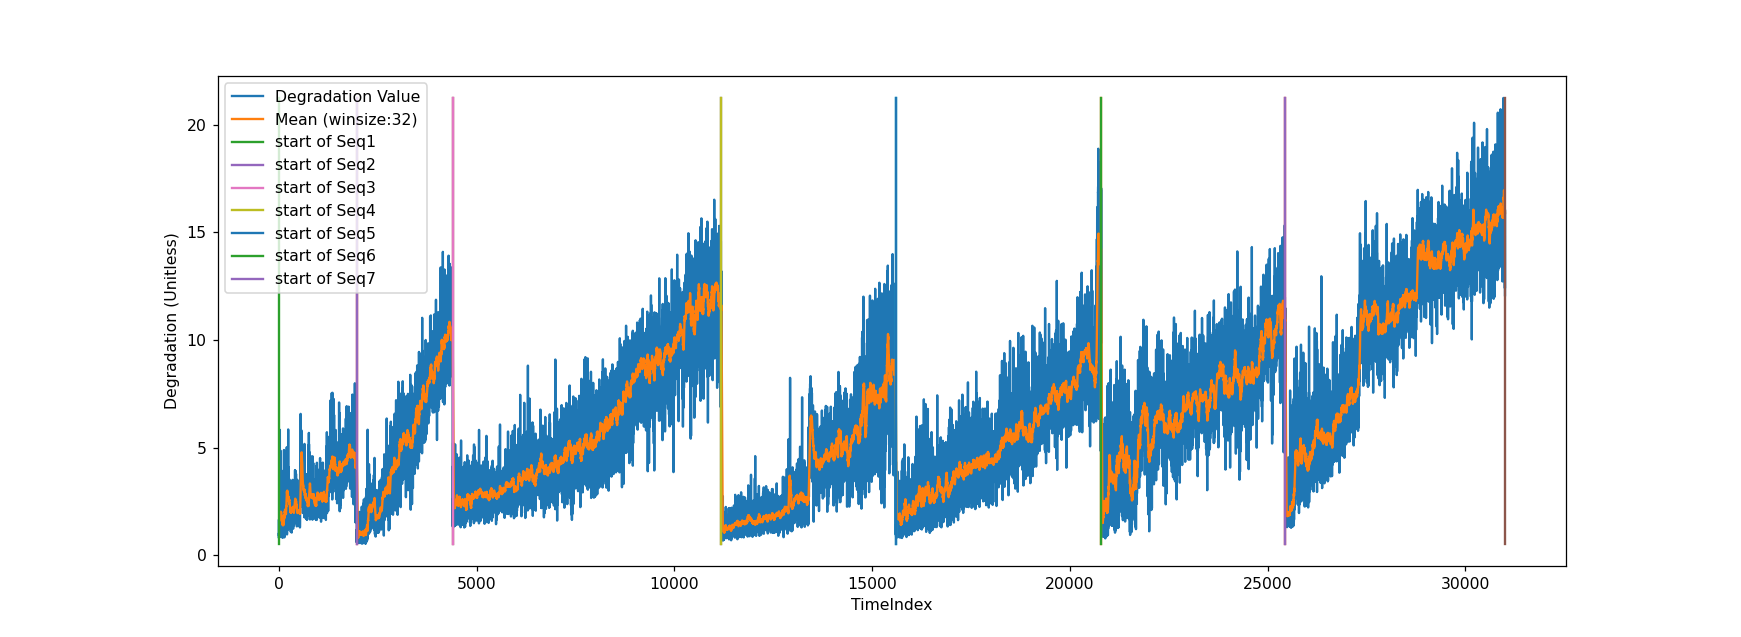

In [36]:
%matplotlib notebook
plt.plot(all_seq_y_tilde_vect, label='Degradation Value')
plt.plot(pd.Series(all_seq_y_tilde_vect).rolling(32).mean(), label='Mean (winsize:32)')

min_y = all_seq_y_tilde_vect.min()
max_y = all_seq_y_tilde_vect.max()

'''
# Type 1 Data with 10 refs clean outliers
seq_period_iloc = [
    [    0,  1988],
    [ 1988, 4432],
    [ 4432, 11242],
    [ 11242, 15654],
    [ 15654, 20662],
    [ 20662, 25335],
    [ 25335, 30888],
]
'''
'''
# Type 1 Data with 10 refs
seq_period_iloc = [
    [    0,  1991],
    [ 1991, 4440],
    [ 4440, 11259],
    [ 11259, 15683],
    [ 15683, 20904],
    [ 20904, 25584],
    [ 25584, 31160],
]
'''

# Type 1 Data with 32 refs
seq_period_iloc = [
    [    0,  1969],
    [ 1969,  4396],
    [ 4396, 11193],
    [ 11193, 15595],
    [ 15595, 20794],
    [ 20794, 25452],
    [ 25452, 31006],
]

seq_index = 1
for stime_iloc, etime_iloc in seq_period_iloc:
    plt.plot([stime_iloc, stime_iloc], [min_y, max_y], label = "start of Seq{}".format(seq_index))
    plt.plot([etime_iloc, etime_iloc], [min_y, max_y])
    seq_index += 1


plt.ylabel("Degradation (Unitless)")
plt.xlabel("TimeIndex")

plt.legend()
plt.show()

In [ ]:
import plotly.graph_objects as go
import pandas as pd
fig = go.Figure()

fig = go.Figure()

plot_raw_pts = True
    
fig.add_trace(
    go.Scatter(
        x=np.arange(all_seq_y_tilde_vect.size),
        y=all_seq_y_tilde_vect,
        mode='lines',
        name = 'Degradation (Unitless)',
        #mode='lines+markers',
    )
)

fig.add_trace(
    go.Scatter(
        x=np.arange(all_seq_y_tilde_vect.size),
        y=pd.Series(all_seq_y_tilde_vect).rolling(32).mean(),
        mode='lines',
        name = 'Mean (winsize:32)'
        #mode='lines+markers',
    )
)

## Find outliers

In [ ]:
all_seq_y_tilde_vect.size

In [ ]:
mov_aver = pd.Series(all_seq_y_tilde_vect).rolling(32, min_periods=1).mean()
rel_outlier_idx = np.abs(all_seq_y_tilde_vect - mov_aver) > 3

In [ ]:
res = all_seq_y_tilde_vect - mov_aver

In [ ]:
y=pd.Series(all_seq_y_tilde_vect).rolling(32).mean()
y_firstpart = pd.Series(all_seq_y_tilde_vect[:32]).rolling(32).mean()

In [ ]:
import plotly.offline as pyo
trace0 = go.Scatter(
            x=np.arange(all_seq_y_tilde_vect.size),
            y=res,
            mode='lines',
            name='Subtract the mean',
            #mode='lines+markers',
    )



trace1 = go.Scatter(
            x= np.arange(all_seq_y_tilde_vect.size),
            y= np.linspace(3, 3,all_seq_y_tilde_vect.size),
            mode='lines',
            name = 'Threshold',
            #mode='lines+markers',
            )

trace2 = go.Scatter(
            x= np.arange(all_seq_y_tilde_vect.size),
            y= np.linspace(-3,-3,all_seq_y_tilde_vect.size),
            mode='lines',
            name = 'Threshold',
            #mode='lines+markers',
            )

# Fill out data with our traces
data = [trace0, trace1,trace2]
# Plot it and save as basic-line.html
pyo.iplot(data, filename = 'basic-line')

In [ ]:
outliers = np.where(abs(res) > 3, True, res)

In [ ]:
outliers[2088]

In [ ]:
index = np.argwhere(outliers == True)

In [ ]:
index

# Test for both dataset

In [ ]:
## Load Data
# 3 Stripes data -- Type 1
data_path_type1 = "../MA/NewData/22008_1000202026_652510007"
fnames_type1 = "Padding_regenerated_roi_ms1_seq{}_720x24.h5" # 0,1,2,3,4,5,6
combined_path_type1 = os.path.join(data_path_type1, fnames_type1)
seq_idx_list_type1 = [0,1,2,3,4,5,6]

#One Stripe Data -- Type 2
data_path_type2 = "../MA/NewData/21503_1000200411_653340003"
fnames_type2 = "trueroi_filtered_phase2_1_{}.h5" # 2,3,4
combined_path_type2 = os.path.join(data_path_type2, fnames_type2)
seq_idx_list_type2 = [2,3,4]

# Dataloader for training set, test set (80%,20%)
inputs_shape = [1,720,24]
batch_sizes = [32, 32]
shuffle_flags = [True, False]
ds_ratio = [0.8, 0.2]

In [ ]:
mean_val = 0
std_val = 255

refs_list, ds_h5_test = init_test_dataset(combined_path_type1, seq_idx_list_type1, mean_val, std_val)
refs_list_1stripe, ds_h5_1stripe = init_dataset(combined_path_type2, seq_idx_list_type2, mean_val, std_val)

In [ ]:
# Combine the datasets for training
refs_list.insert(1,refs_list_1stripe[0])
refs_list.insert(3,refs_list_1stripe[1])
refs_list.insert(5,refs_list_1stripe[2])

ds_h5_test.insert(1,ds_h5_1stripe[0])
ds_h5_test.insert(3,ds_h5_1stripe[1])
ds_h5_test.insert(5,ds_h5_1stripe[2])

# Initialize dataloaders
dataloaders = init_dataloaders(ds_h5_test, ds_ratio)
train_dls = [dls[0] for dls in dataloaders]
valid_dls = [dls[1] for dls in dataloaders]

In [ ]:
len(ds_h5_test)

In [ ]:
batch_size = 1
test_dataloaders = []
for ds in ds_h5_test: 
    test_dataloader = DataLoader(dataset = ds, batch_size=batch_size, shuffle = False)
    test_dataloaders.append(test_dataloader)

In [ ]:
all_seq_y_tilde_vect = np.zeros(0)
time_ids = []

for refs,dl in zip(refs_list, test_dataloaders):

    curr_refs = refs.float().to(device)
    num_data = len(dl)
    print(num_data)
    
    loss_vect = np.zeros(num_data)
    var_res_vect= np.zeros(num_data)

    y_vect = np.zeros(num_data)
    y_tilde_vect = np.zeros(num_data)
    
    dl_iter = iter(dl)

    for i in tqdm(range(num_data)):
        try:
            img,label = next(dl_iter)

        except (StopIteration, TypeError):
            dl_iter = iter(curr_train_dl)
            img,label = next(dl_iter)
            
        y_vect[i] = label
        
        img = img.float().to(device)
                
        #targets = targets.float().to(device)
        
        #v1, refs_v = model.forward_test(img, curr_refs)
        #metric = degradation_metrics(v1,refs_v)
        
        metric = model.forward(img, curr_refs)
        
        y_tilde = metric.detach().cpu().numpy()

        var_res_vect[i] = np.var(y_tilde)

        y_tilde_vect[i] = y_tilde.mean()

        loss_vect[i] = np.abs(label - y_tilde_vect[i])
        
    time_ids.append(y_tilde_vect.size)
        
    all_seq_y_tilde_vect = np.concatenate((all_seq_y_tilde_vect, y_tilde_vect))

In [ ]:
%matplotlib notebook
plt.plot(all_seq_y_tilde_vect, label='Degradation Value')
plt.plot(pd.Series(all_seq_y_tilde_vect).rolling(32).mean(), label='Mean (winsize:32)')

min_y = all_seq_y_tilde_vect.min()
max_y = all_seq_y_tilde_vect.max()

'''
# Type 1 Data with 10 refs clean outliers
seq_period_iloc = [
    [    0,  1988],
    [ 1988, 4432],
    [ 4432, 11242],
    [ 11242, 15654],
    [ 15654, 20662],
    [ 20662, 25335],
    [ 25335, 30888],
]
'''
# Type 1 Data with 10 refs
seq_period_iloc = [
    [    0,  1991],
    [ 1991, 4440],
    [ 4440, 11259],
    [ 11259, 15683],
    [ 15683, 20904],
    [ 20904, 25584],
    [ 25584, 31160],
]



'''
# Type 1 Data with 32 refs
seq_period_iloc = [
    [    0,  1969],
    [ 1969,  4396],
    [ 4396, 11193],
    [ 11193, 15595],
    [ 15595, 20794],
    [ 20794, 25452],
    [ 25452, 31006],
]
'''
seq_index = 1
for stime_iloc, etime_iloc in seq_period_iloc:
    plt.plot([stime_iloc, stime_iloc], [min_y, max_y], label = "start of Seq{}".format(seq_index))
    plt.plot([etime_iloc, etime_iloc], [min_y, max_y])
    seq_index += 1


plt.ylabel("Degradation (Unitless)")
plt.xlabel("TimeIndex")

plt.legend()
plt.show()